# 신경망 성능 개선

신경망의 예측 성능 및 수렴 성능을 개선하기 위해서는 다음과 같은 추가적인 고려를 해야 한다.

* 크로스 엔트로피(cross-entropy) 오차함수
* hyper-tangent and ReLu 활성화 함수
* 가중치 초기값 정규화(Weight normalizatio )
* Drop-out 정규화(Regularization)
* Softmax 출력
* 배치 정규화(Batch Normalization)


## 크로스 엔트로피 오차함수

크로스 엔트로피(Cross-Entropy) 형태의 오차함수를 사용하면 출력 레이어에서 활성화 함수의 도함수에 의한 영향을 제거할 수 있다.

$$
\begin{eqnarray} 
  C = y \log z^{(L)} + (1-y) \log (1-z^{(L)})
\end{eqnarray}
$$

이 경우 출력 레이어의 가중치에 대한 미분값은 다음과 같아진다.

$$
\begin{eqnarray}
\frac{\partial C}{\partial w_j^{(L)}} 
&=& \left(\frac{y }{z^{(L)}} - \frac{(1-y)}{1-z^{(L)}} \right) \frac{\partial z^{(L)}}{\partial w_j^{(L)}} \\
&=& \left(\frac{y}{\sigma(a)} - \frac{(1-y)}{1-\sigma(a)} \right)\sigma'(a) z^{(l-1)}_j \\
&=& \frac{\sigma'(a) }{\sigma(a) (1-\sigma(a))} (\sigma(a)-y) z^{(l-1)}_j  \\
&=& (\sigma(a)-y) z^{(l-1)}_j \\ 
&=& (z^{(L)}-y) z^{(l-1)}_j \\ 
\\
\frac{\partial C}{\partial b^{(L)}} &=&  z^{(L)} - y
\end{eqnarray}
$$

## Keras 에서 크로스 엔트로피 사용

Keras에서는 ``compile`` 메서드의 ``loss`` 인수를 설정하여 크로스 엔트로피를 포함한 다양한 오차함수를 사용할 수 있다.
``loss`` 인수에서 설정 가능한 값 중 몇 가지 예를 들면 다음과 같다.

* ``mean_squared_error``
* ``mean_squared_logarithmic_error``
* ``mean_absolute_error``
* ``mean_absolute_percentage_error``
* ``binary_crossentropy``
* ``categorical_crossentropy``

In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # warning 출력 방지
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

X_train = X_train0.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test0.reshape(10000, 784).astype('float32') / 255.0
Y_train = np_utils.to_categorical(y_train0, 10)
Y_test = np_utils.to_categorical(y_test0, 10)

np.random.seed(0)
model0 = Sequential()
model0.add(Dense(15, input_dim=784, activation="sigmoid"))
model0.add(Dense(10, activation="sigmoid"))
model0.compile(optimizer=SGD(lr=0.2),
               loss='mean_squared_error', metrics=["accuracy"])

Using TensorFlow backend.


In [2]:
%%time
hist0 = model0.fit(X_train, Y_train, epochs=30, batch_size=100,
                   validation_data=(X_test, Y_test), verbose=0)

CPU times: user 26.8 s, sys: 7.57 s, total: 34.4 s
Wall time: 24.6 s


In [3]:
np.random.seed(0)
model1 = Sequential()
model1.add(Dense(15, input_dim=784, activation="sigmoid"))
model1.add(Dense(10, activation="sigmoid"))
model1.compile(optimizer=SGD(lr=0.2),
               loss='categorical_crossentropy', metrics=["accuracy"])

In [4]:
%%time
hist1 = model1.fit(X_train, Y_train, epochs=30, batch_size=100,
                   validation_data=(X_test, Y_test), verbose=0)

CPU times: user 29.3 s, sys: 8.56 s, total: 37.9 s
Wall time: 26.1 s


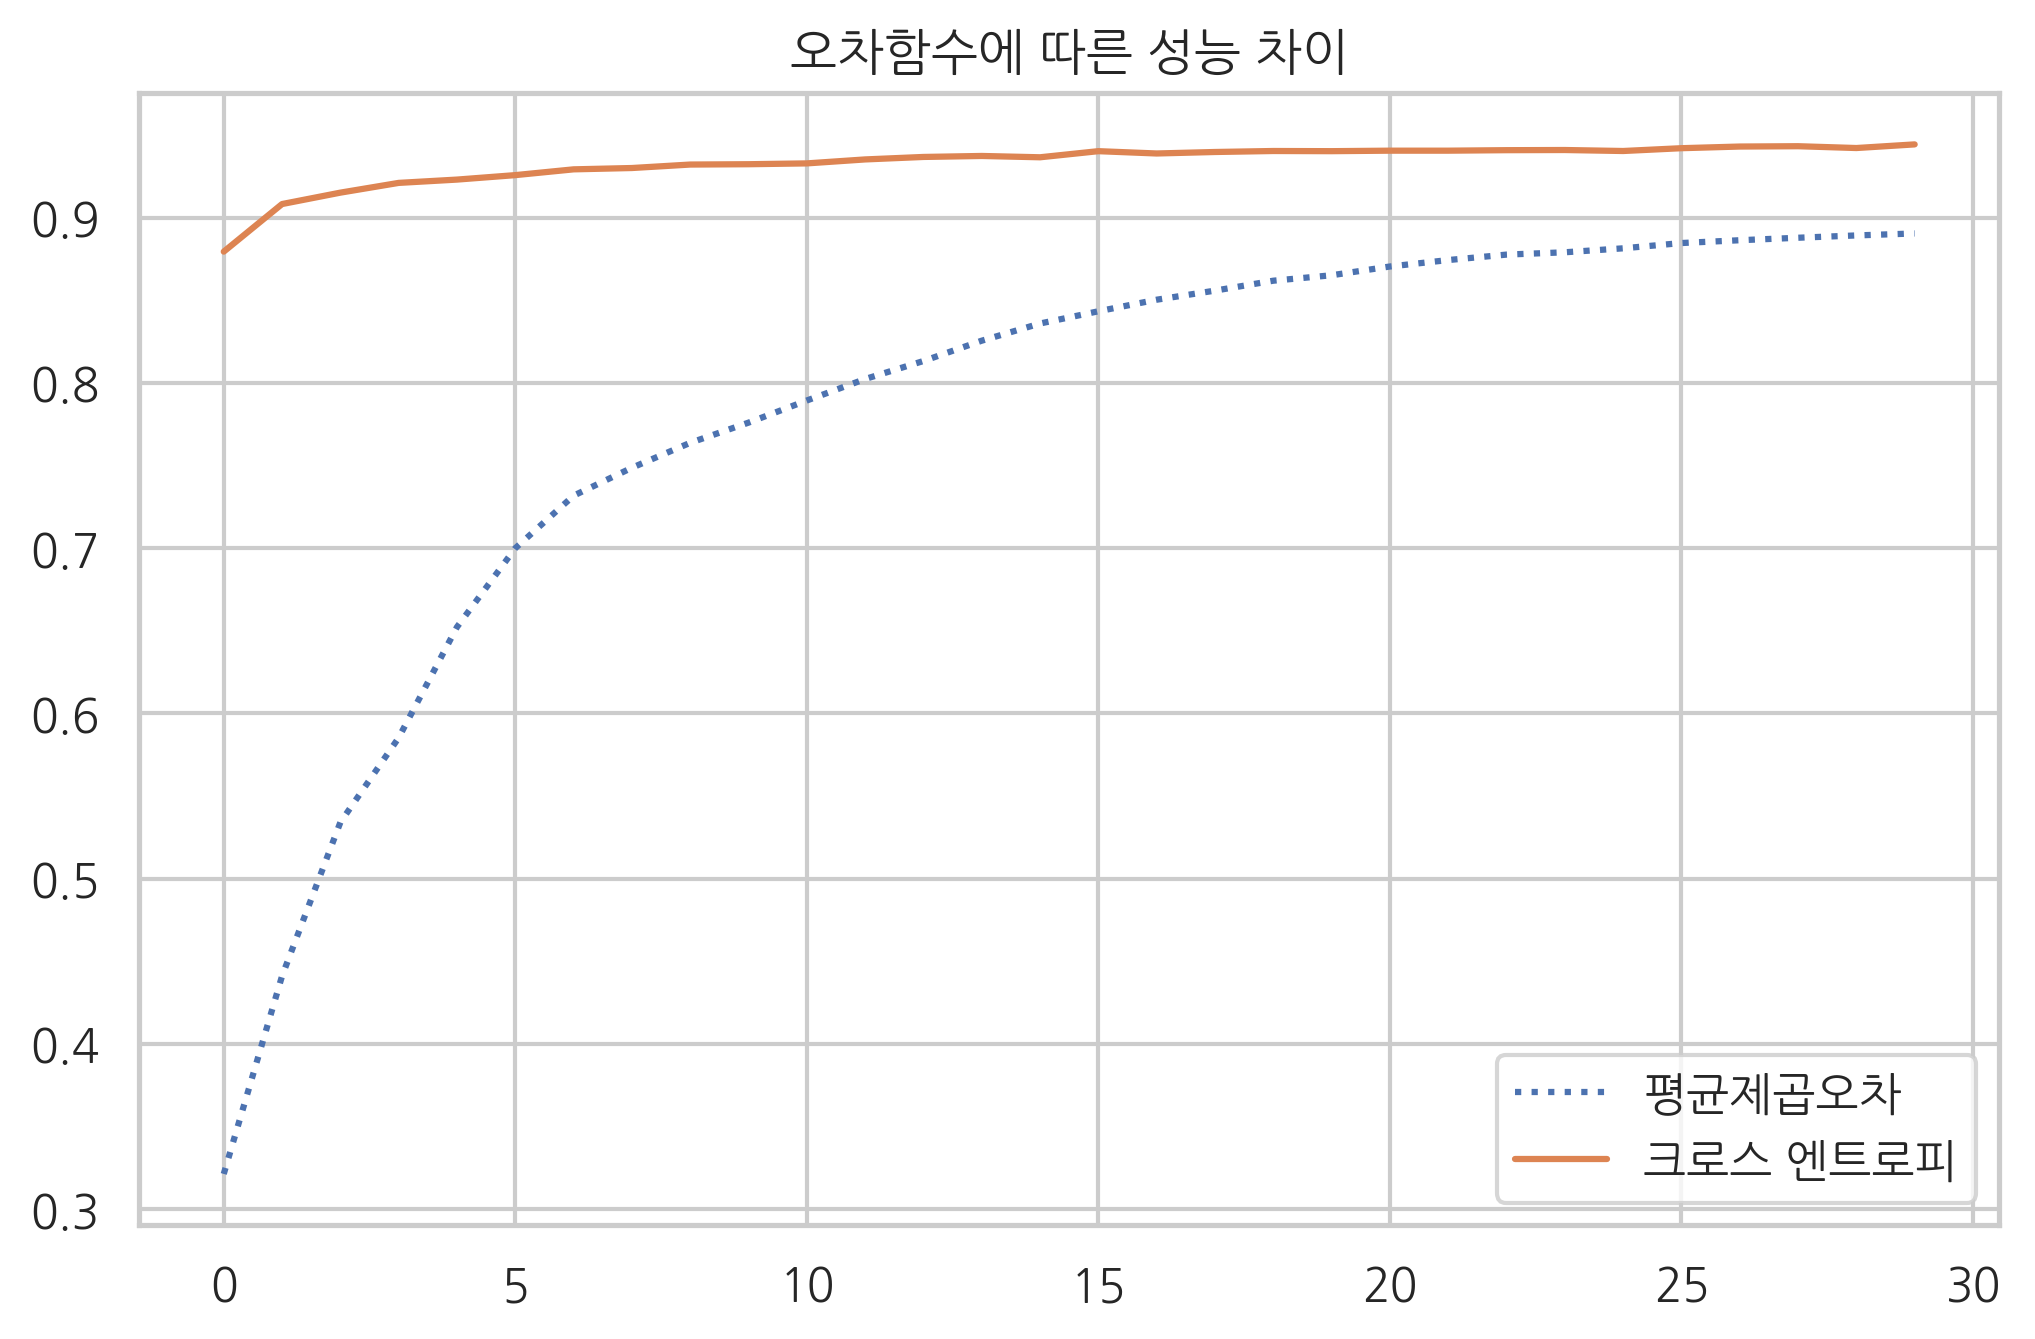

In [5]:
plt.plot(hist0.history['val_acc'], ls=":", label="평균제곱오차")
plt.plot(hist1.history['val_acc'], label="크로스 엔트로피")
plt.legend()
plt.title("오차함수에 따른 성능 차이")
plt.show()

## 하이퍼탄젠트 활성화 함수

활성화 함수로 로지스틱 함수 대신 하이퍼탄젠트(Hypertangent)를 사용하면 도함수의 최댓값이 로지스틱 함수의 4배인 1이 되므로 그레디언트 감소 현상이 줄어든다.

$$
\begin{eqnarray}
  \tanh(a) \equiv \frac{e^a-e^{-a}}{e^a+e^{-a}} = 2\sigma(2a) - 1
\end{eqnarray}
$$

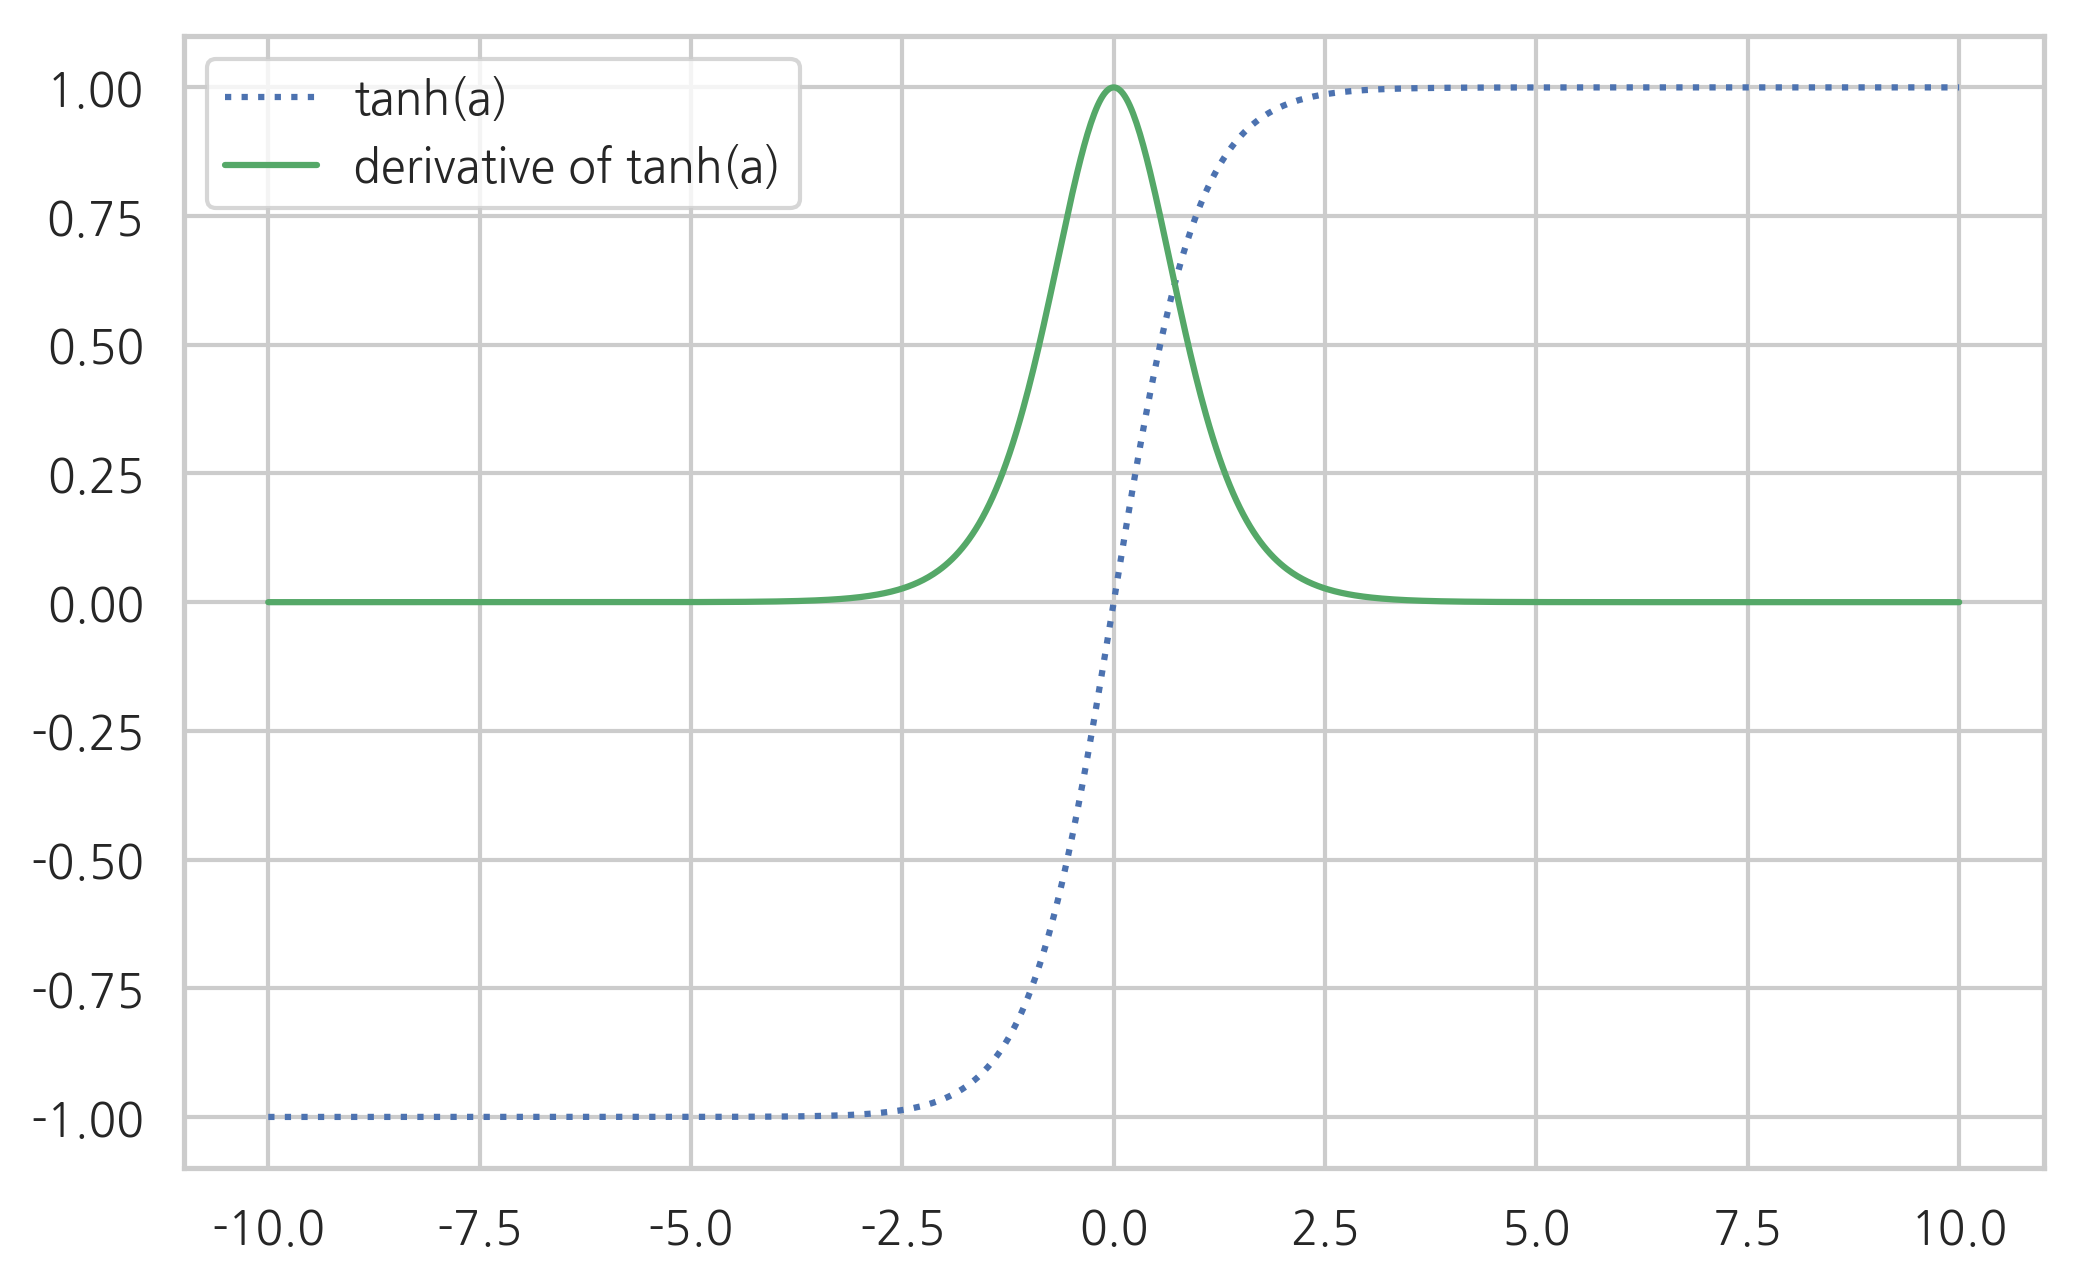

In [6]:
def tanh(x): 
    return np.tanh(x)

def tanh_prime(x): 
    return 1 - np.tanh(x) ** 2


xx = np.linspace(-10, 10, 1000)
plt.plot(xx, tanh(xx), 'b:', label="tanh(a)")
plt.plot(xx, tanh_prime(xx), 'g-', label="derivative of tanh(a)")
plt.legend()
plt.show()

## Rectified Linear Unit (ReLu)  활성화 함수

가장 좋은 방법은 Rectified Linear Unit (ReLu) 활성화 함수를 사용하는 것이다. ReLu는 가중치총합 $a$가 큰 경우에도 기울기(gradient)가 1로 유지되므로 $a$이 커도 그레디언트 감소 현상이 발생하지 않는다. CNN과 같이 레이어의 수가 많은 경우에 유용하다.

$$
\begin{eqnarray}
  \max(0, a)
\end{eqnarray}
$$

$a$가 음수인 경우에도 기울기가 0이 되지 않도록 하는 Leaky ReLu도 사용한다.

$$
\begin{eqnarray}
  \max(\alpha a, a) \;\; (0 < \alpha < 1)
\end{eqnarray}
$$


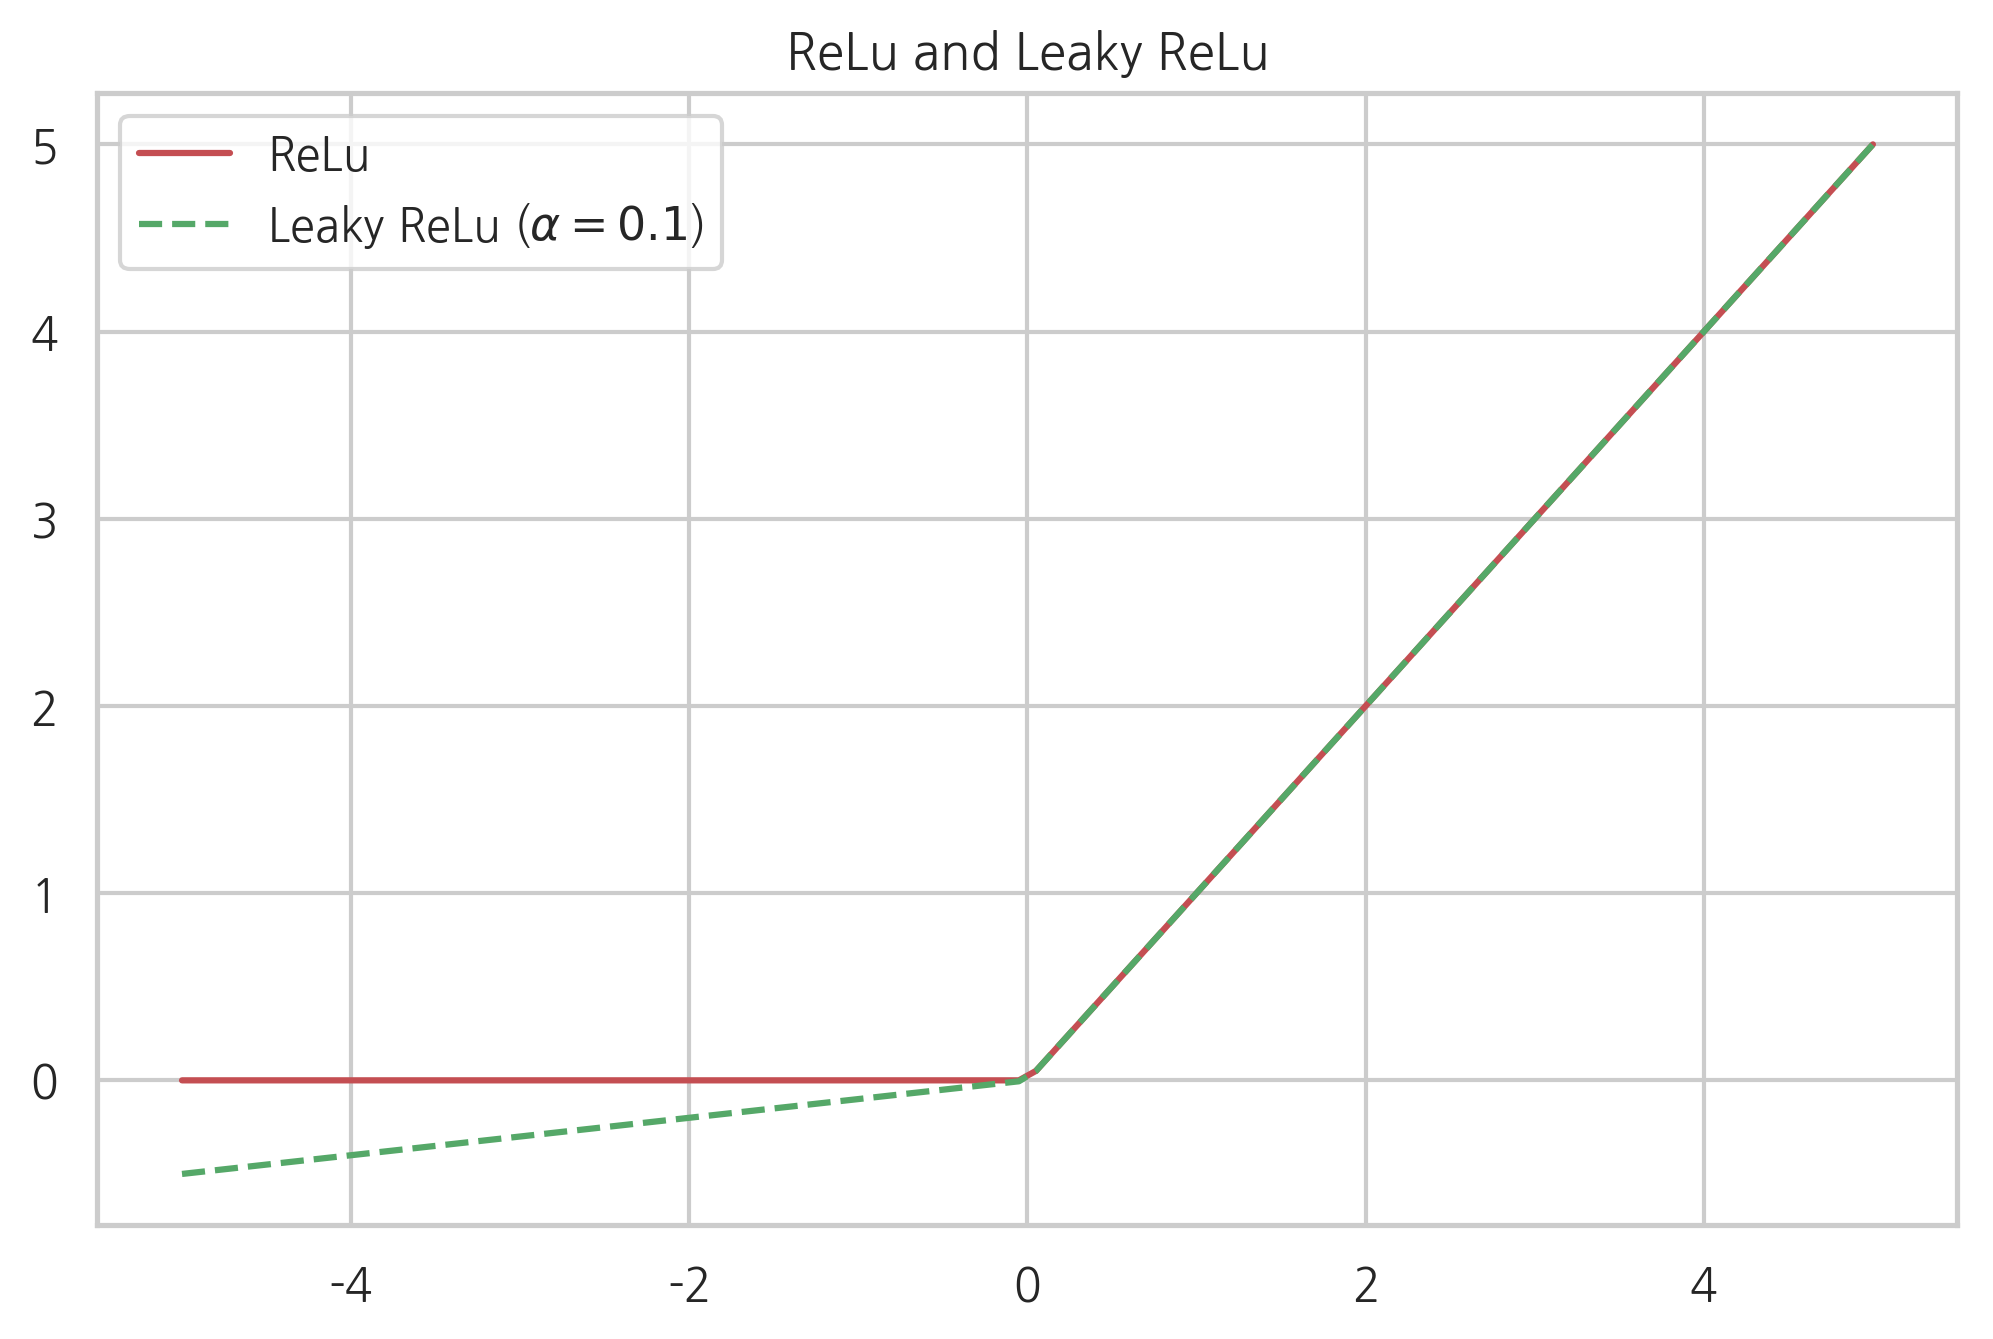

In [7]:
a = np.linspace(-5, 5, 100)
relu = np.maximum(0, a)
leakyrelu = np.maximum(0.1 * a, a)
plt.plot(a, relu, 'r-', label="ReLu")
plt.plot(a, leakyrelu, 'g--', label="Leaky ReLu ($\\alpha=0.1$)")
plt.title("ReLu and Leaky ReLu")
plt.legend()
plt.show()

Keras에서는 Dense 네트워크를 생성할 때 `activation` 인수의 값을 바꿀 수 있다.

* ``sigmoid``
* ``tanh``
* ``relu``

In [8]:
np.random.seed(0)
model2 = Sequential()
model2.add(Dense(15, input_dim=784, activation="tanh"))
model2.add(Dense(10, activation="sigmoid"))
model2.compile(optimizer=SGD(lr=0.2),
               loss='mean_squared_error', metrics=["accuracy"])

In [9]:
%%time
hist2 = model2.fit(X_train, Y_train, epochs=30, batch_size=100,
                   validation_data=(X_test, Y_test), verbose=0)

CPU times: user 27.5 s, sys: 7.08 s, total: 34.6 s
Wall time: 24.6 s


In [10]:
np.random.seed(0)
model3 = Sequential()
model3.add(Dense(15, input_dim=784, activation="relu"))
model3.add(Dense(10, activation="sigmoid"))
model3.compile(optimizer=SGD(lr=0.2),
               loss='mean_squared_error', metrics=["accuracy"])

In [11]:
%%time
hist3 = model3.fit(X_train, Y_train, epochs=30, batch_size=100,
                   validation_data=(X_test, Y_test), verbose=0)

CPU times: user 27.5 s, sys: 7.11 s, total: 34.6 s
Wall time: 24.7 s


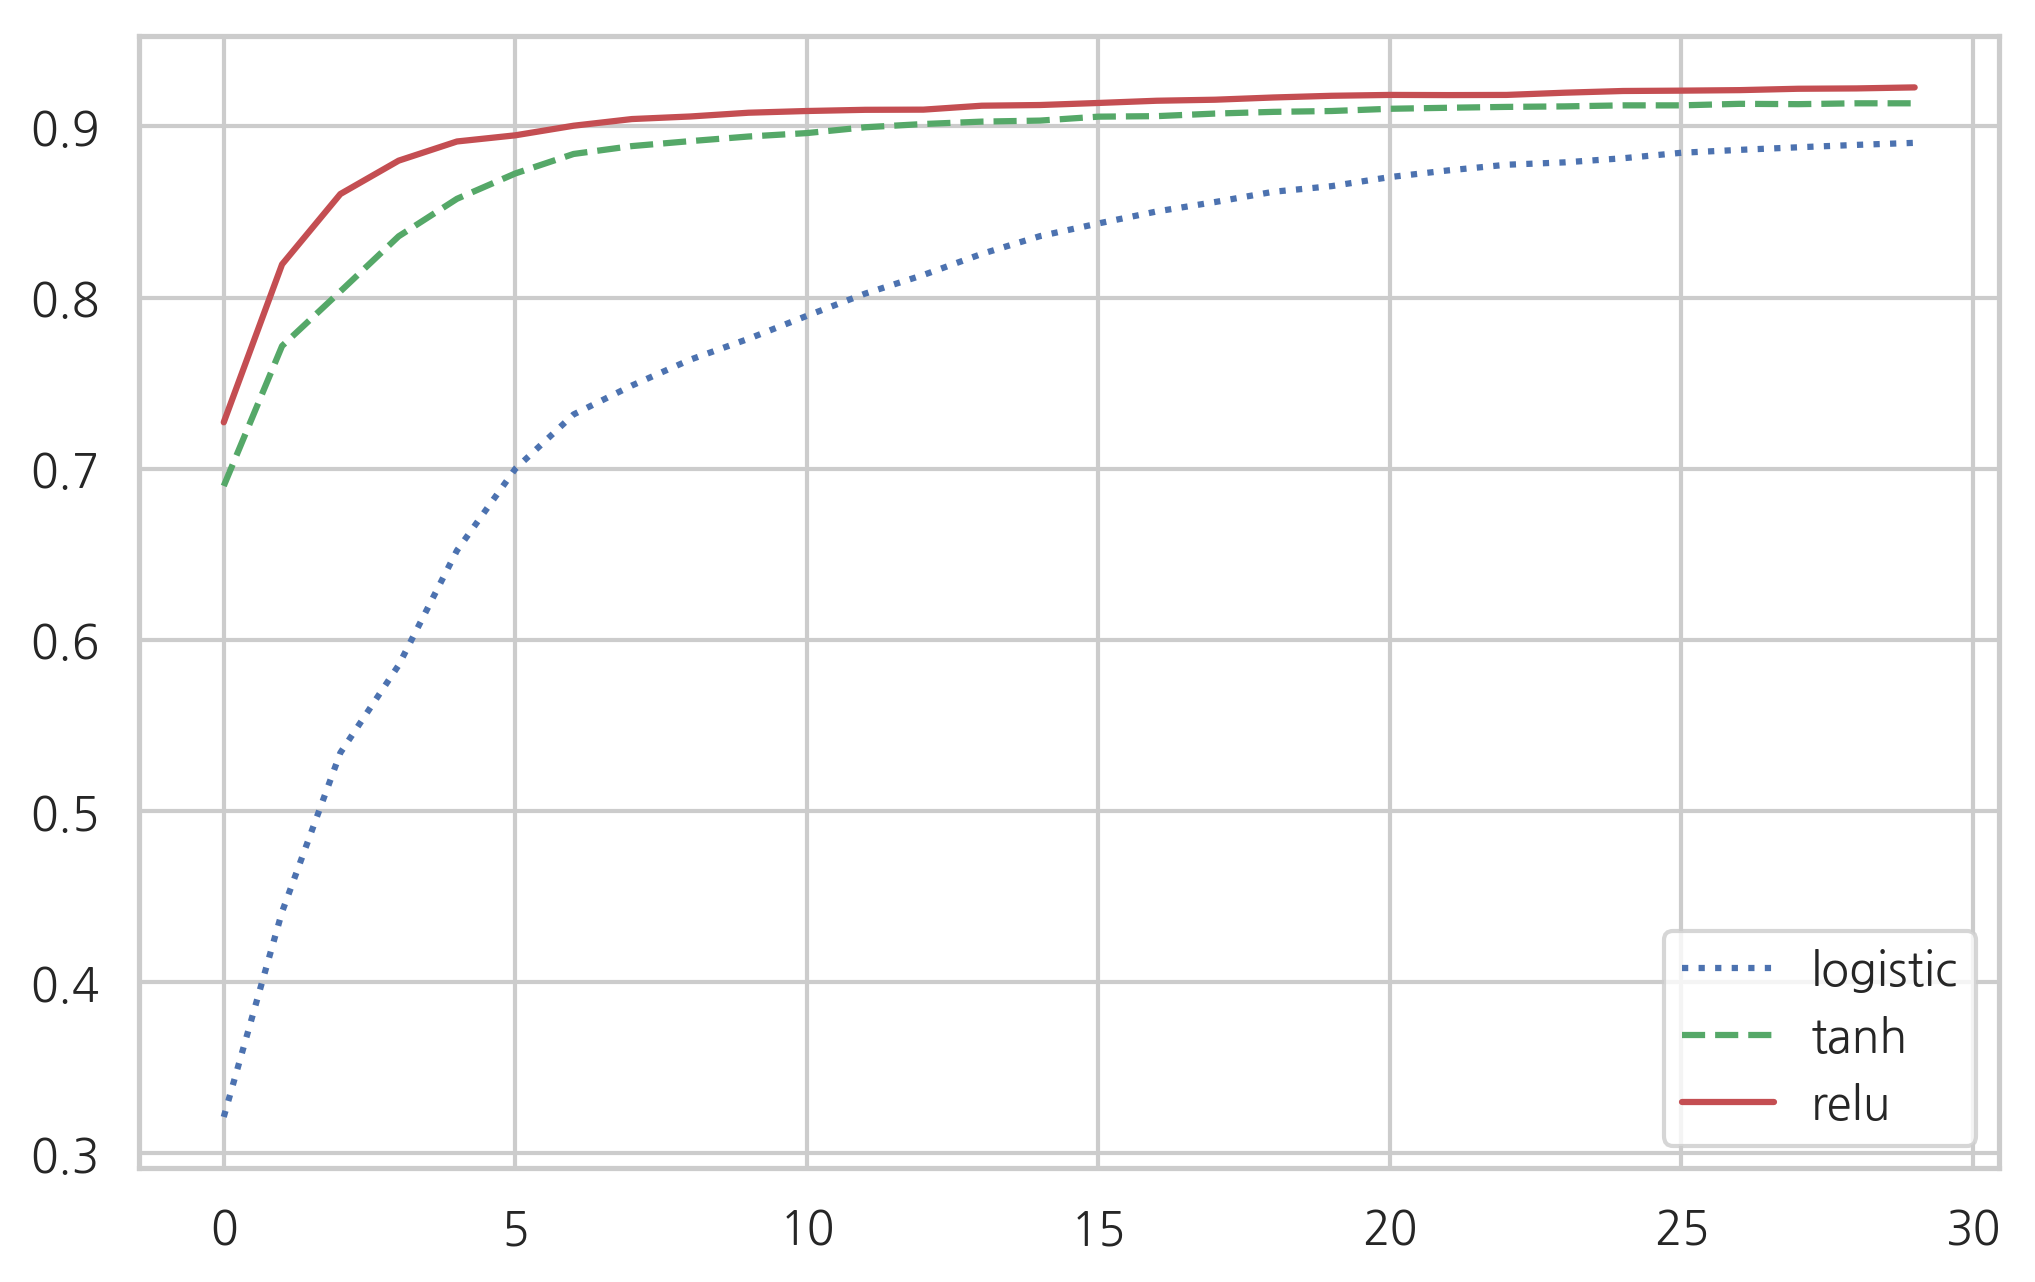

In [12]:
plt.plot(hist0.history['val_acc'], 'b:', label="logistic")
plt.plot(hist2.history['val_acc'], 'g--', label="tanh")
plt.plot(hist3.history['val_acc'], 'r-', label="relu")
plt.legend()
plt.show()

## 초기 가중치 정규화

활성화값 $a$는 입력변수 벡터 $x$와 가중치 벡터 $w$의 내적이다. 

$$ a = w^Tx $$

가중치 벡터 $w$의 초기값은 가우시안 정규 분포 또는 유니폼 분포에 따라 무작위로 설정하는데

정규분포 표본의 합의 표준편차는 표본 수의 제곱근에 비례하므로 입력변수 벡터 $x$의 차원 $n_{in}$가 증가하면 활성화값 $a$ 값의 표준편차(standard deviation)도 증가한다.

$$ \text{std}(a) \propto \sqrt{n_{in}} $$
 
예를 들어 1000개의 픽셀로 이루어진 이미지 입력을 사용하는 경우를 가정해보자. 만약 이미지를 구성하는 픽셀의 절반 정도가 1(검은색)이라는 값을 가지고 나머지 절반 정도가 0(흰색)을 가진다면  활성화값 $a$는 500개의 가우시안 정규 분포 표본의 합이 된다. 약 22.4이다.

$$ \sqrt{500} \approx 22.4 $$

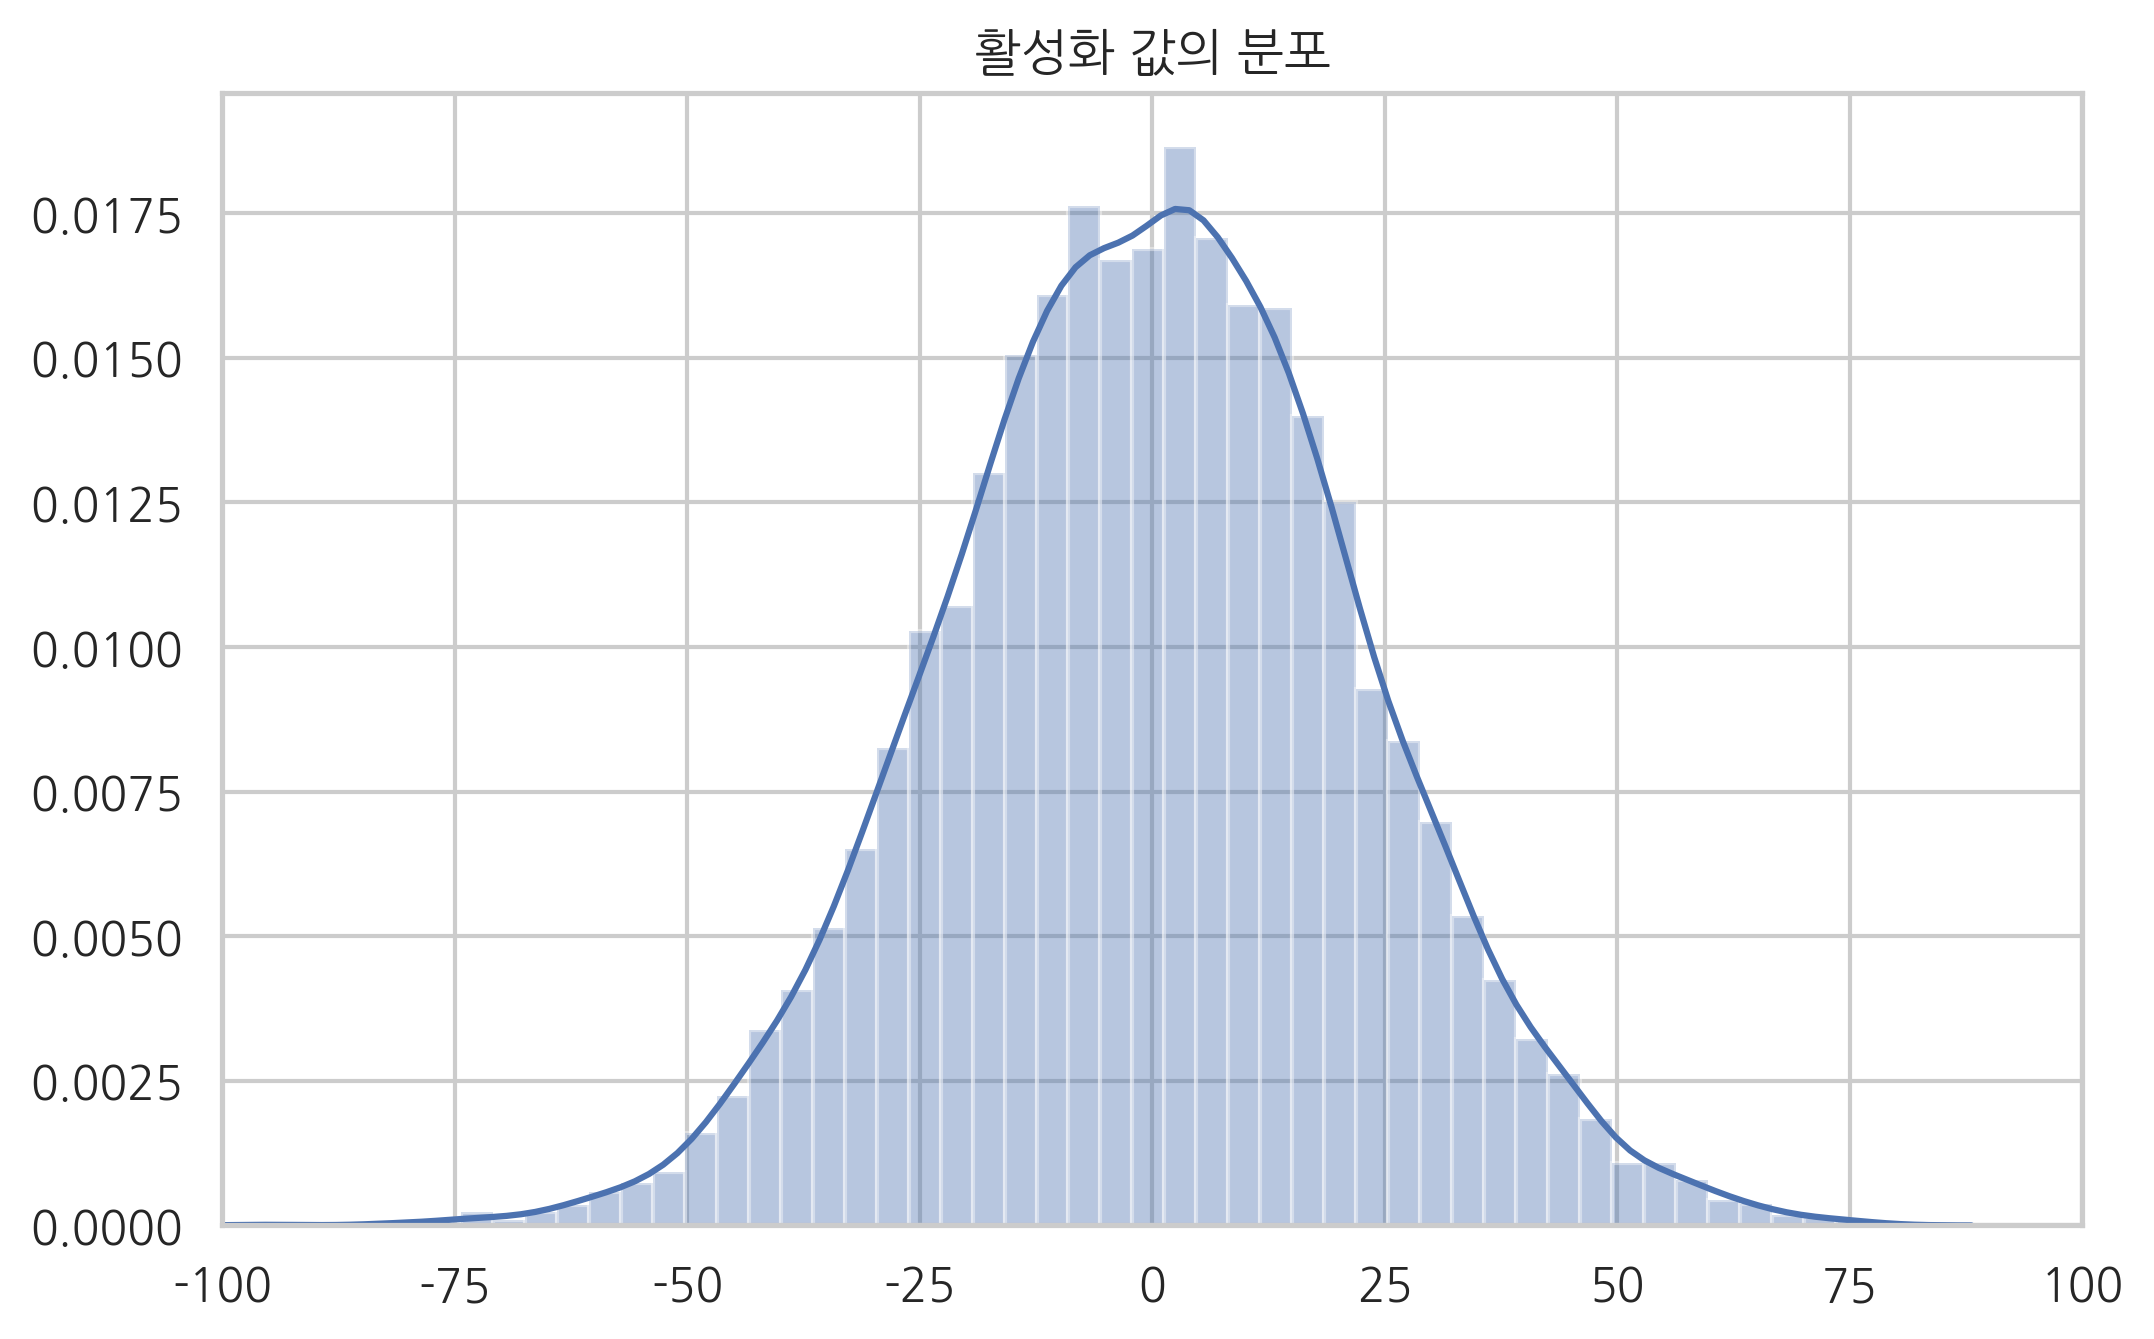

In [13]:
np.random.seed(0)
sns.distplot(np.random.randn(500, 10000).sum(axis=0))
plt.title("활성화 값의 분포")
plt.xlim(-100, 100)
plt.show()

이렇게 표준 편차가 크면 수렴이 느려지기 때문에 입력 수에 따라 초기화 가중치의 표준편차를 감소하는 초기화 값 조정이 필요하다.
2010년 Xavier Glorot는 반복실험을 통해 다음과 같은 폭을 가진 유니폼 분포를 추천하였다.

$$w \sim \text{uniform}(-\text{limit},\text{limit}) $$

$$\text{limit} = \sqrt{\dfrac{6}{(n_{\text{in}} + n_{\text{out}})}}$$

Keras에서는 `kernel_initializer` 인수로 가중치 초기화 방법을 바꿀 수 있다. 가능한 인수는 다음과 같은 것들이 있다.

* ``random_uniform``
* ``random_normal``
* ``glorot_uniform``
* ``glorot_normal``
* ``lecun_uniform``
* ``lecun_normal``


In [14]:
np.random.seed(0)
model4 = Sequential()
model4.add(Dense(100, kernel_initializer="normal", activation="sigmoid", input_dim=784))
model4.add(Dense(10, kernel_initializer="normal", activation="sigmoid"))
model4.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [15]:
%%time
hist4 = model4.fit(X_train, Y_train, epochs=30, batch_size=100, verbose=0)

CPU times: user 44.3 s, sys: 13.5 s, total: 57.7 s
Wall time: 35.5 s


In [16]:
np.random.seed(0)
model5 = Sequential()
model5.add(Dense(100, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.add(Dense(10, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [17]:
%%time
hist5 = model5.fit(X_train, Y_train, epochs=10, batch_size=100, verbose=0)

CPU times: user 15.2 s, sys: 4.24 s, total: 19.5 s
Wall time: 12 s


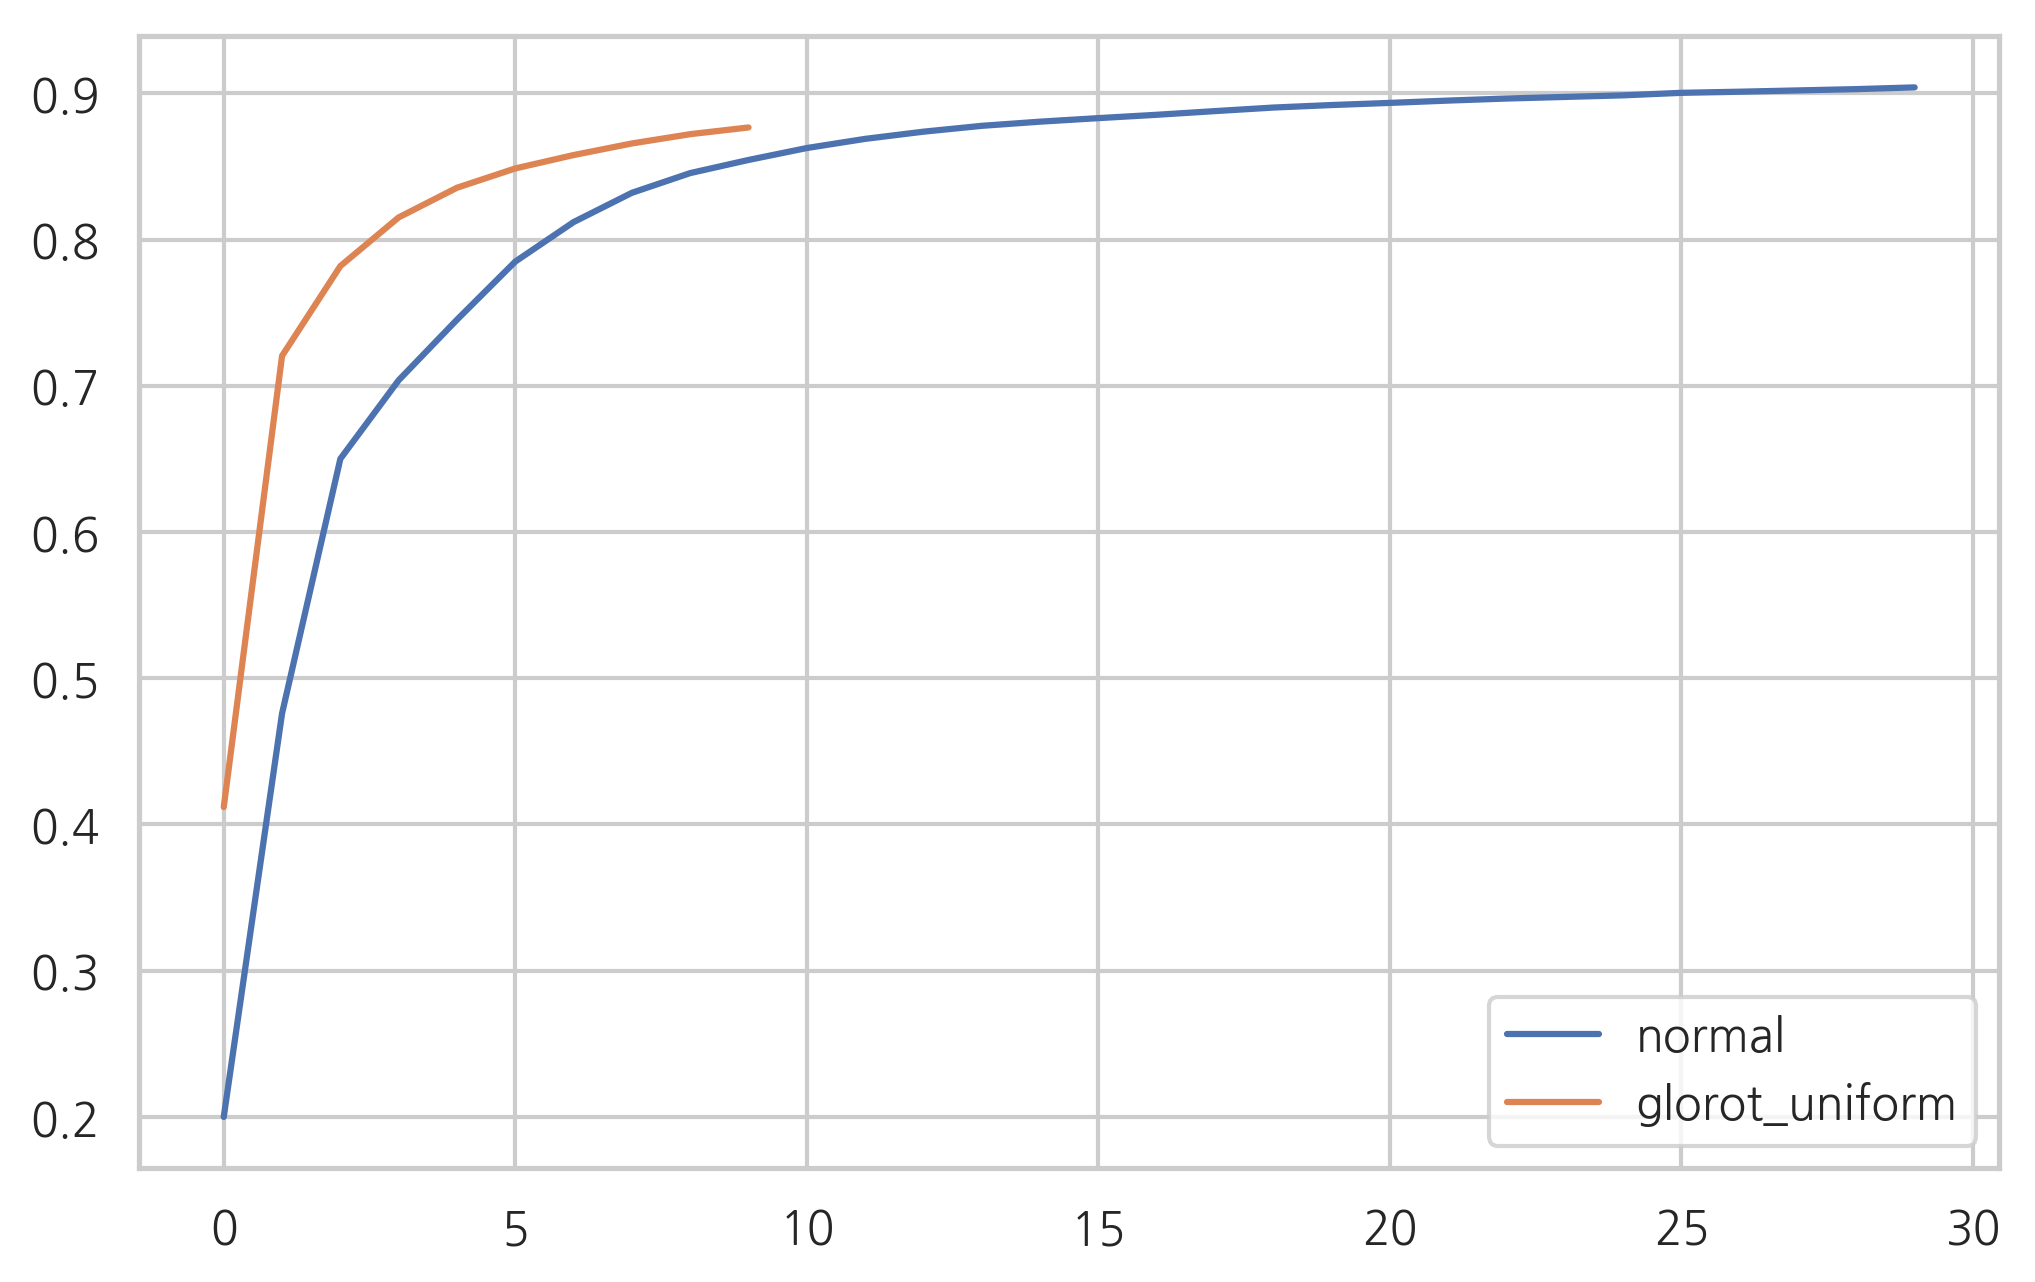

In [18]:
plt.plot(hist4.history['acc'], label="normal")
plt.plot(hist5.history['acc'], label="glorot_uniform")
plt.legend()
plt.show()

## 과최적화 문제

신경망 모형은 파라미터의 수가 다른 모형에 비해 많다. 이렇게 파라미터의 수가 많으면 과최적화 발생 가능성이 증가한다. 즉, 정확도가 나아지지 않거나 나빠져도 오차 함수는 계속 감소하는 현상이 발생한다.

In [19]:
np.random.seed(0)
model6 = Sequential()
model6.add(Dense(30, input_dim=784, activation="sigmoid"))
model6.add(Dense(10, activation="sigmoid"))
model6.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [20]:
%%time
hist6 = model6.fit(X_train, Y_train, epochs=30, batch_size=100,
                   validation_data=(X_test, Y_test), verbose=0)

CPU times: user 34.9 s, sys: 10.4 s, total: 45.2 s
Wall time: 29.6 s


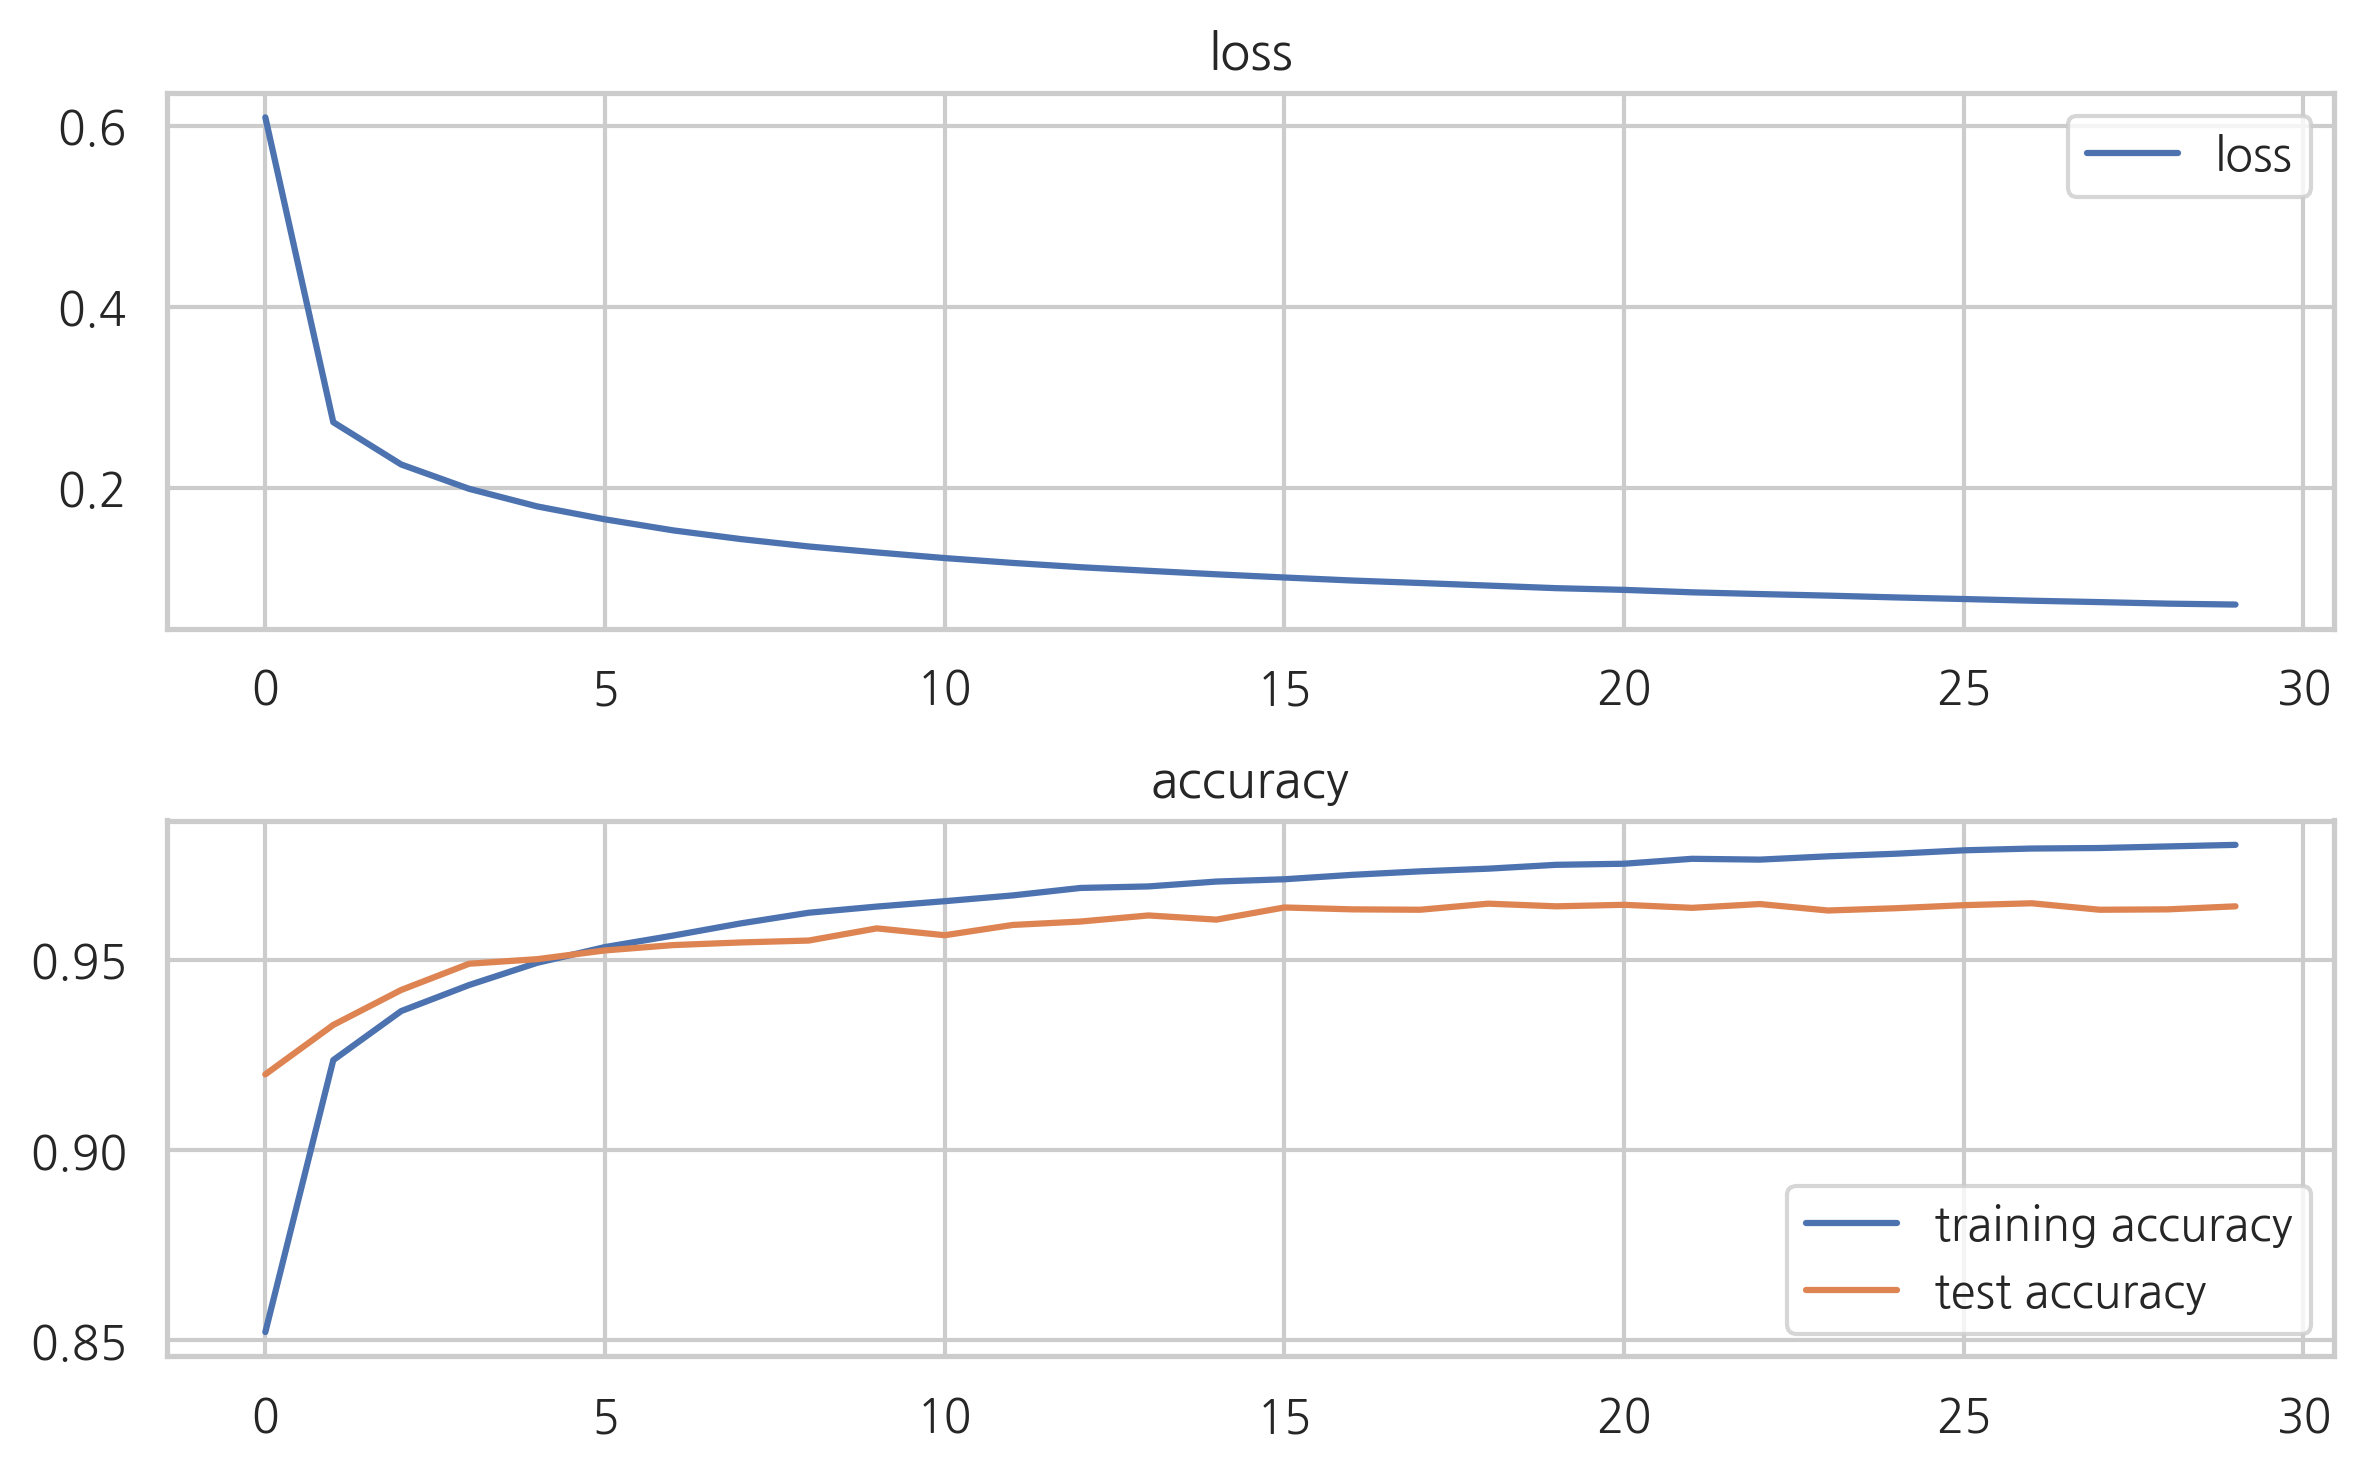

In [21]:
plt.subplot(211)
plt.plot(hist6.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist6.history['acc'], label="training accuracy")
plt.plot(hist6.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## L1, L2 정규화

L1 정규화는 오차 함수에 가중치 행렬의 L1 놈을 추가하는 방법이다.

$$
C = - (y \log z+(1-y) \log(1-z)) + \lambda \sum_i |w_i|
$$

L2 정규화는 오차 함수에 가중치 행렬의 L2 놈을 추가한다.

$$
C = - (y \log z+(1-y) \log(1-z)) + \lambda \sum_i w_i^2
$$


Keras에서는 레이어 생성시에 `kernel_regularizer` 인수로 `regularizers` 서브패키지의 `l1`, `l2` regularizer 객체를 넣어서 L1, L2 정규화를 구현한다.

In [22]:
from keras import regularizers

np.random.seed(0)
model7 = Sequential()
model7.add(Dense(30, input_dim=784, activation="sigmoid", kernel_regularizer=regularizers.l2(0.001)))
model7.add(Dense(10, activation="sigmoid"))
model7.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [23]:
%%time
hist7 = model7.fit(X_train, Y_train, epochs=30, batch_size=100,
                   validation_data=(X_test, Y_test), verbose=0)

CPU times: user 36.6 s, sys: 12.7 s, total: 49.3 s
Wall time: 31.2 s


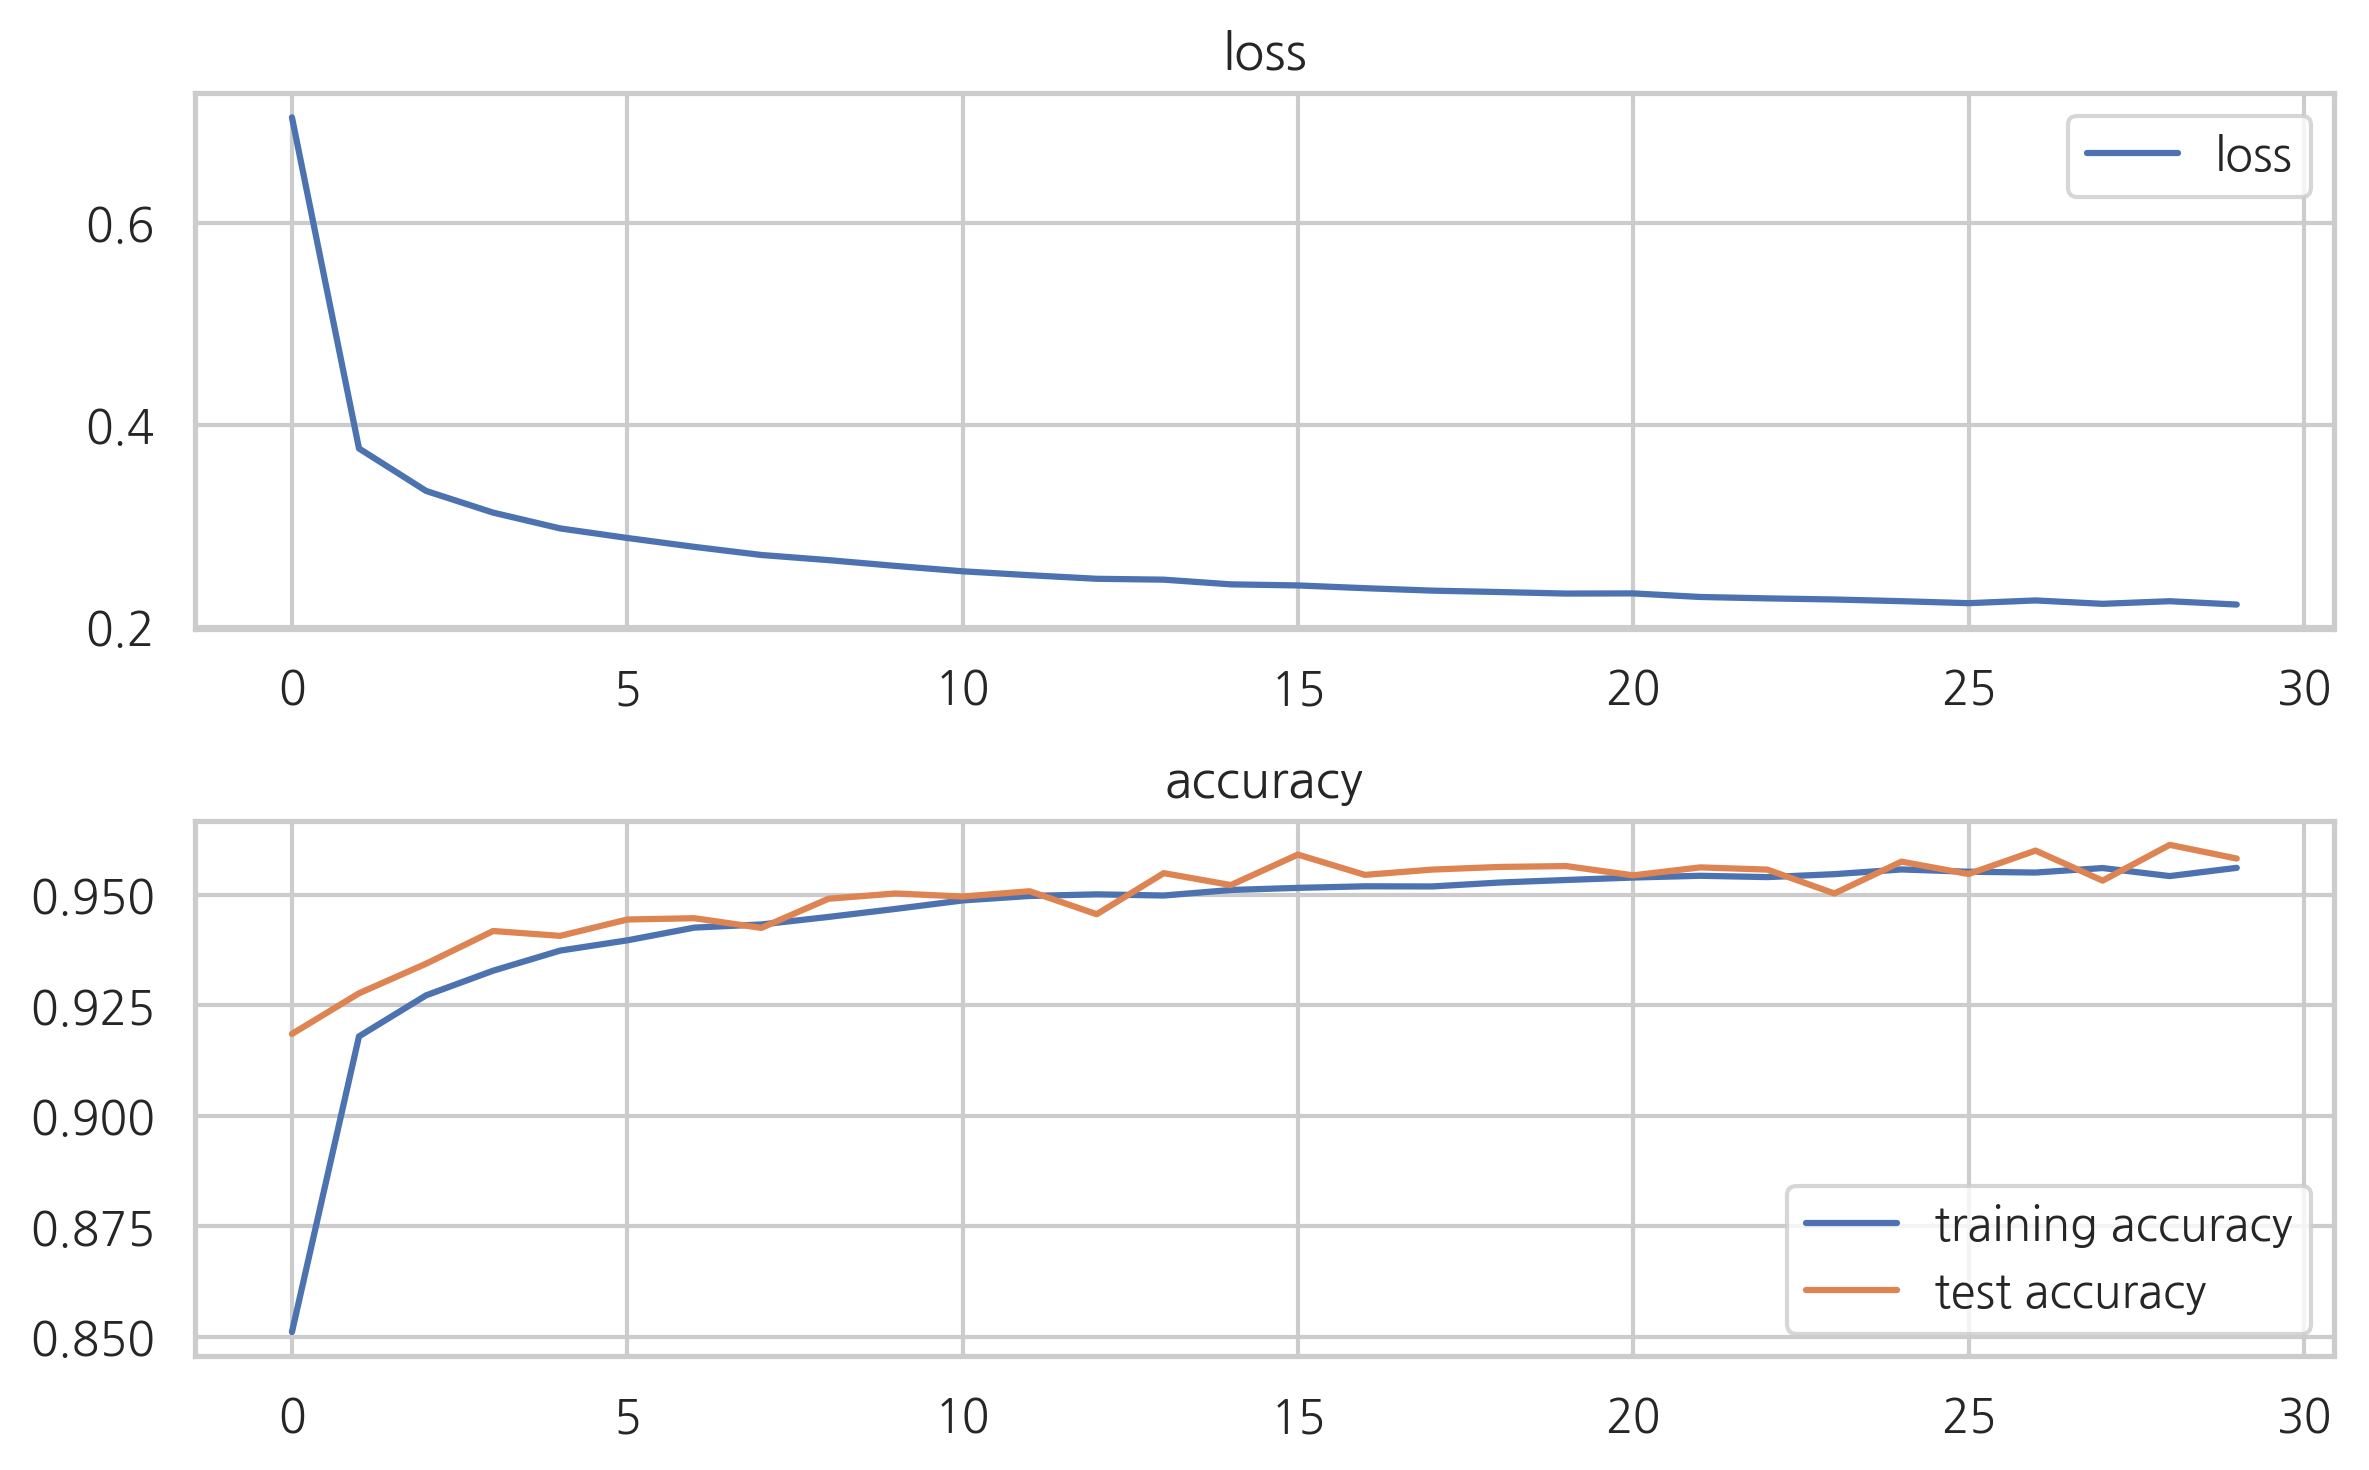

In [24]:
plt.subplot(211)
plt.plot(hist7.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist7.history['acc'], label="training accuracy")
plt.plot(hist7.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## Dropout 정규화

Dropout 정규화 방법은 이러한 문제를 해결하기 위해 에포크 마다 임의의 은닉계층 뉴런의 $p$%를(보통 절반) dropout 하여 최적화 과정에 포함하지 않는 방법이다. 이 방법을 사용하면 가중치 값들이 특정한 뉴런에만 집중되는 것을 방지하여 정규화 효과를 가져다 준다.

<img src="https://datascienceschool.net/upfiles/88b2bf7f587a493d99c6f27c06731bf3.png" style="width: 100%;">

그림 55.1 : Dropout

테스트 시점에는 가중치에 $p$를 곱하여 스케일링한다.

<img src="https://datascienceschool.net/upfiles/49d909b76da1454f80592241633dbbcb.png" style="width: 100%;">

그림 55.2 : 트레이닝/테스트 시의 Dropout

Keras에서 dropout 정규화는 레이어 뒤에 `Dropout` 객체를 추가하여 구현한다.

In [25]:
from keras.layers import Dropout

np.random.seed(0)
model8 = Sequential()
model8.add(Dense(30, input_dim=784, activation="sigmoid"))
model8.add(Dropout(0.1))
model8.add(Dense(10, activation="sigmoid"))
model8.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

In [26]:
%%time
hist8 = model8.fit(X_train, Y_train, epochs=30, batch_size=100,
                   validation_data=(X_test, Y_test), verbose=0)

CPU times: user 38.6 s, sys: 11.3 s, total: 49.9 s
Wall time: 31.3 s


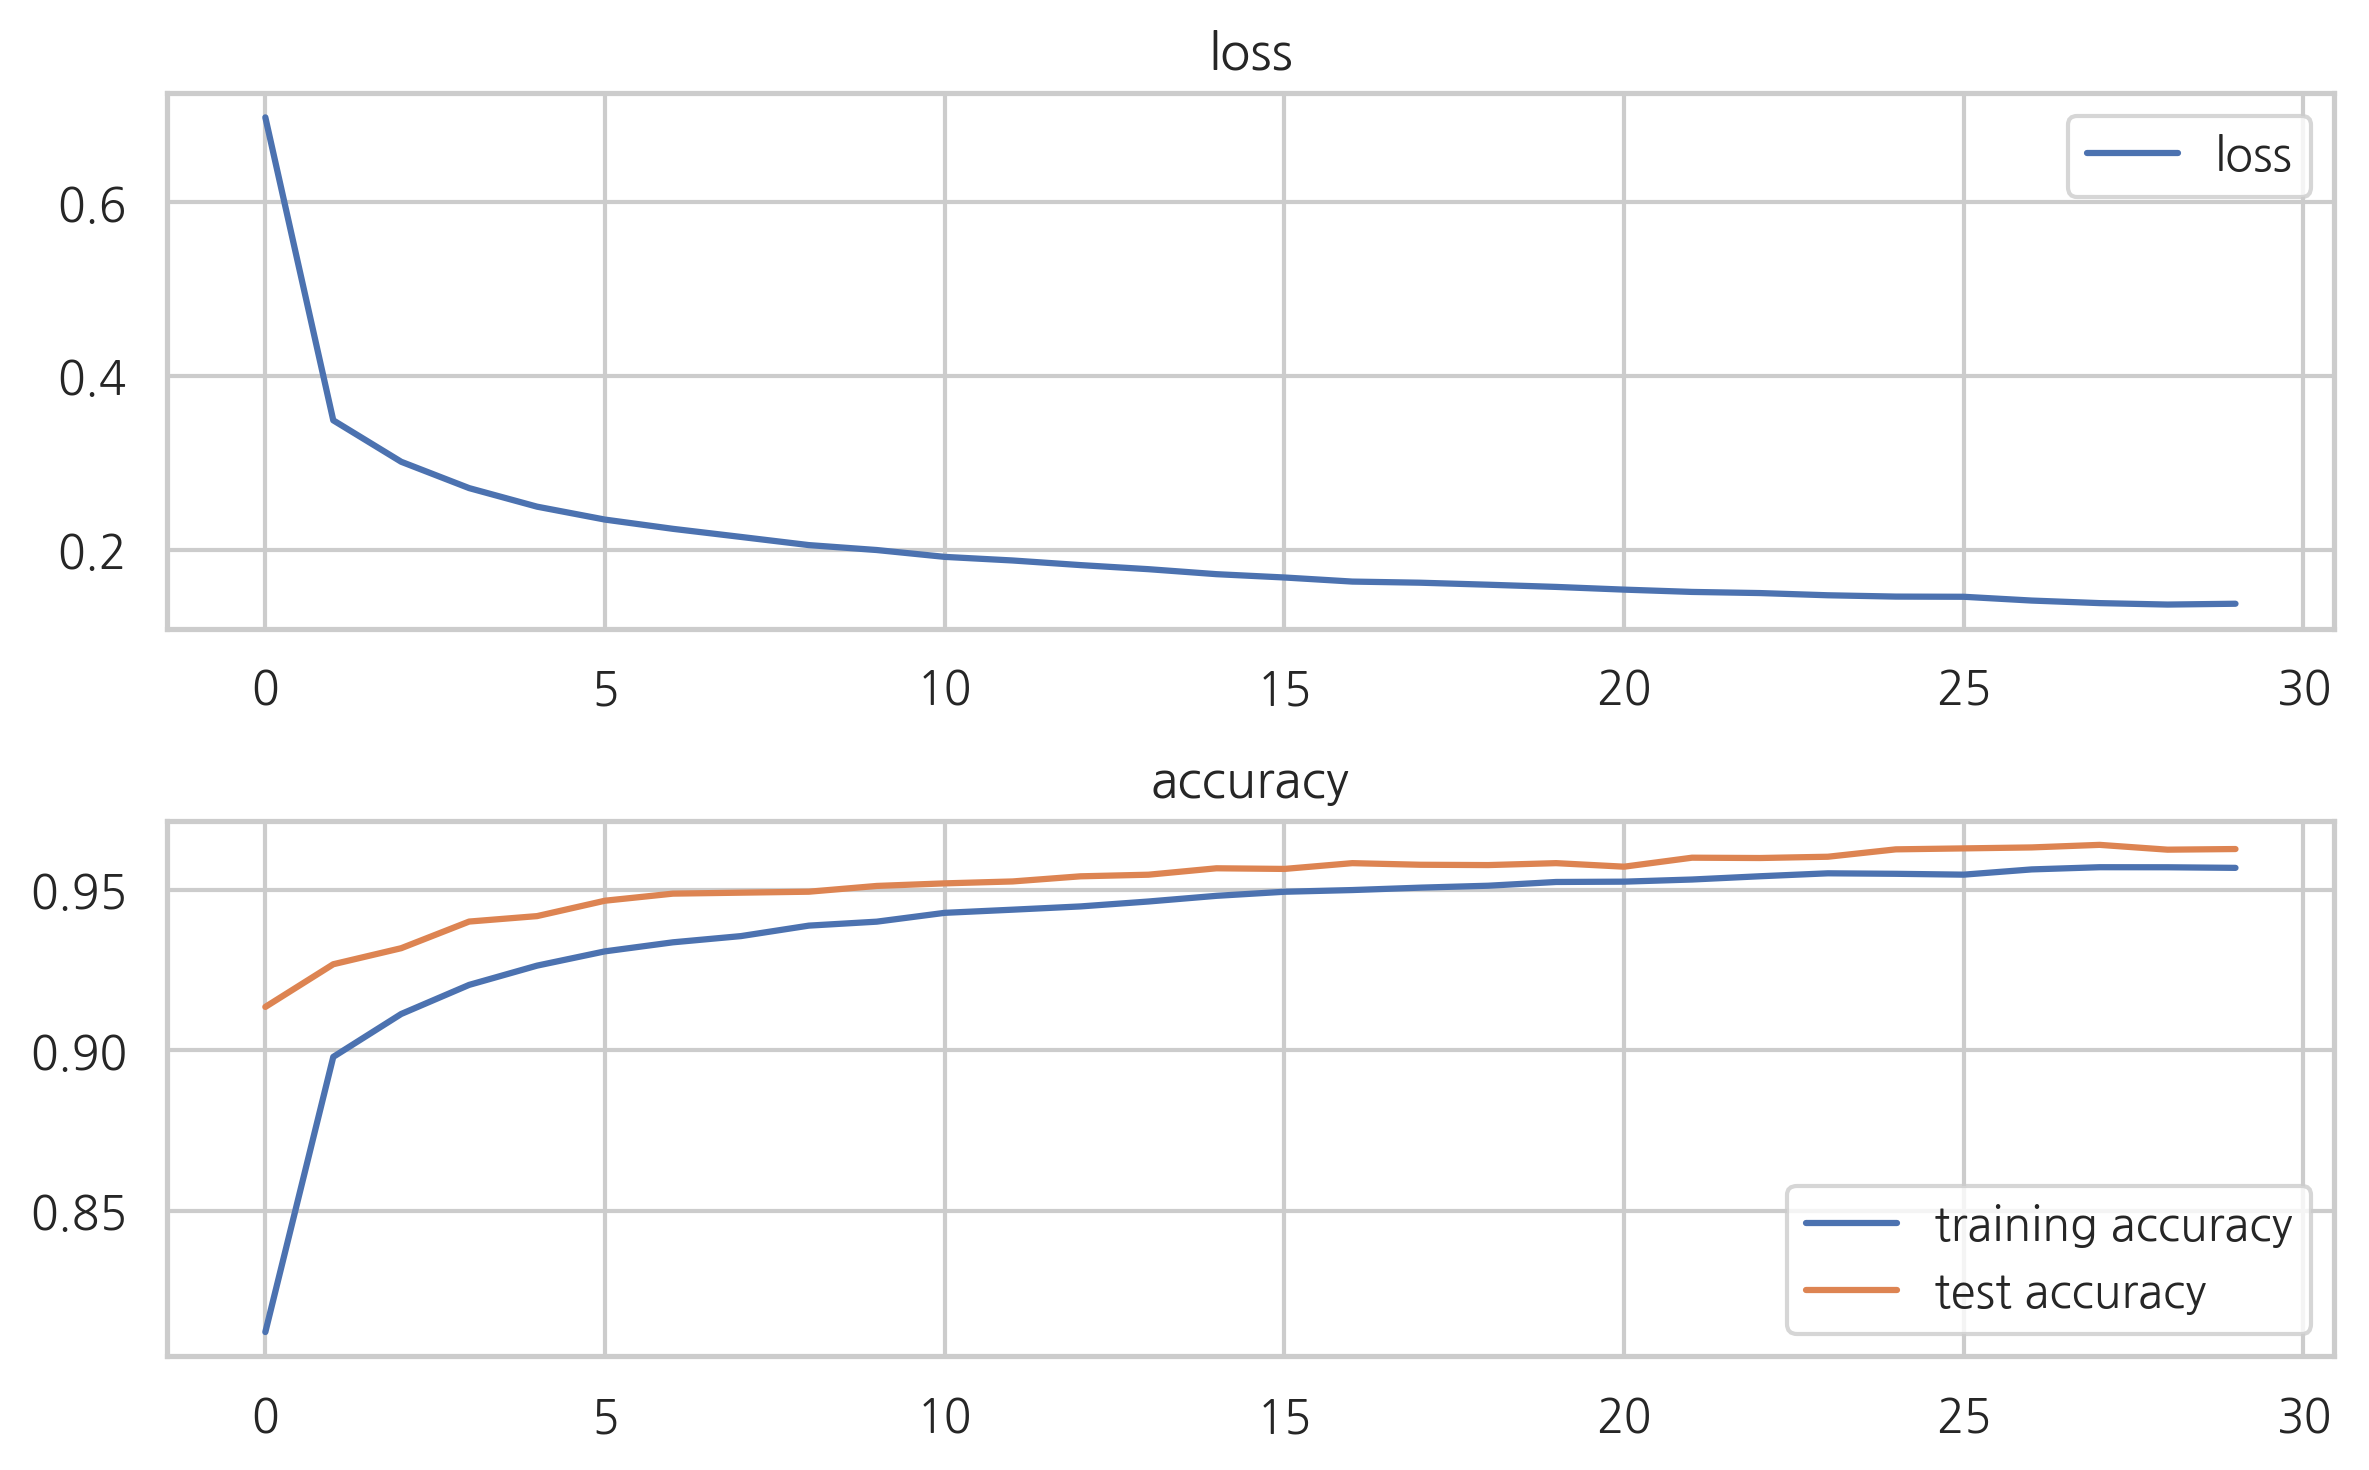

In [27]:
plt.subplot(211)
plt.plot(hist8.history['loss'], label="loss")
plt.legend()
plt.title("loss")
plt.subplot(212)
plt.plot(hist8.history['acc'], label="training accuracy")
plt.plot(hist8.history['val_acc'], label="test accuracy")
plt.legend()
plt.title("accuracy")
plt.tight_layout()
plt.show()

## 소프트맥스 출력 

소프트맥스(softmax) 함수는 입력과 출력이 다변수(multiple variable) 인 함수이다. 최고 출력의 위치를 변화하지 않으면서 츨력의 합이 1이 되도록 조정하기 때문에 출력에 확률론적 의미를 부여할 수 있다. 보통 신경망의 최종 출력단에 적용한다.



$$
\begin{eqnarray} 
  y^L_j = \frac{e^{a^L_j}}{\sum_k e^{a^L_k}},
\end{eqnarray}
$$



$$
\begin{eqnarray}
  \sum_j y^L_j & = & \frac{\sum_j e^{a^L_j}}{\sum_k e^{a^L_k}} = 1
\end{eqnarray}
$$

In [28]:
from ipywidgets import interactive
from IPython.display import Audio, display


def softmax_plot(z1=0, z2=0, z3=0, z4=0):
    exps = np.array([np.exp(z1), np.exp(z2), np.exp(z3), np.exp(z4)])
    exp_sum = exps.sum()
    plt.bar(range(len(exps)), exps/exp_sum, align="center")
    plt.ylim(0, 1)
    plt.xticks([])


v = interactive(softmax_plot, z1=(-3, 5, 0.01), z2=(-3, 5, 0.01), z3=(-3, 5, 0.01), z4=(-3, 5, 0.01))
display(v)

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-3.0, step=0.01), FloatSlider(valu…

Keras에서 출력단의 소프트맥스 활성화 함수는 `activation` 인수의 값을 "softmax"로 지정하여 구현한다.

In [29]:
np.random.seed(0)
model9 = Sequential()
model9.add(Dense(15, input_dim=784, activation="sigmoid",kernel_initializer="glorot_uniform"))
model9.add(Dense(10, activation="softmax",kernel_initializer="glorot_uniform"))
model9.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [30]:
%%time
hist9 = model9.fit(X_train, Y_train, epochs=10, batch_size=10, verbose=0)

CPU times: user 1min, sys: 18.8 s, total: 1min 19s
Wall time: 1min 1s


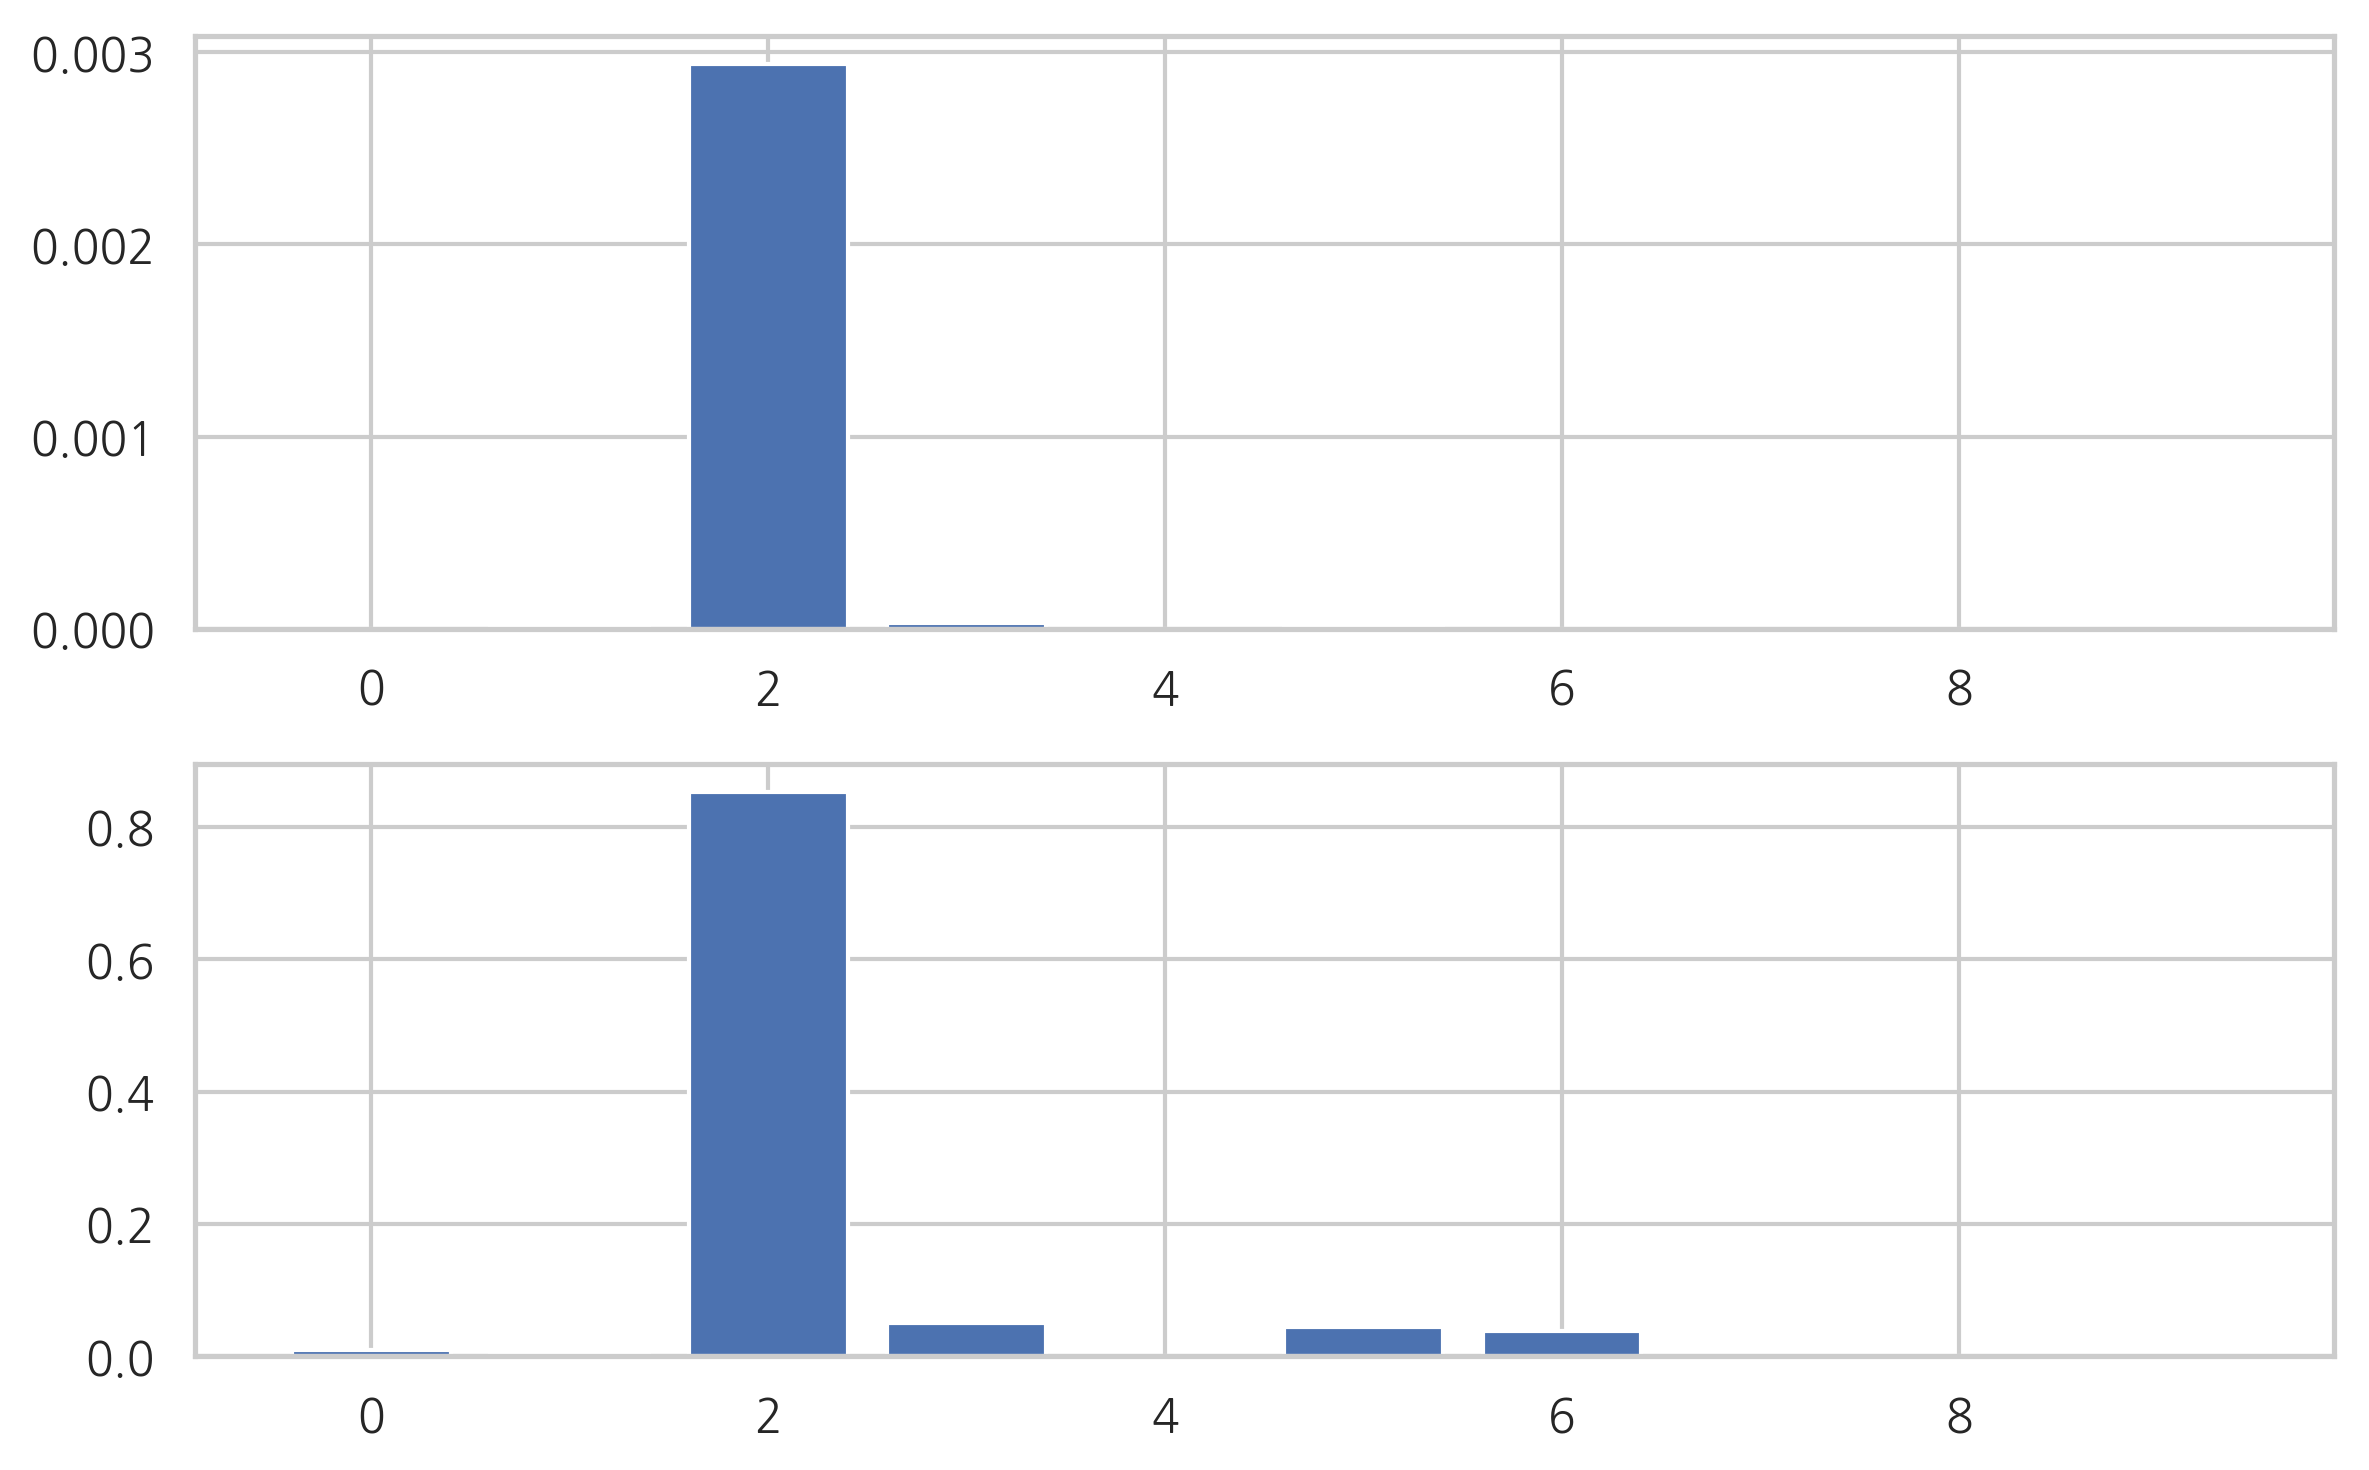

In [31]:
k = 1
y8 = model8.predict(X_test[k:k+1, :])[0]
y9 = model9.predict(X_test[k:k+1, :])[0]

plt.subplot(211)
plt.bar(range(len(y8)), y8, align="center")
plt.subplot(212)
plt.bar(range(len(y9)), y9, align="center")
plt.tight_layout()
plt.show()

## 배치 정규화

배치 정규화(Batch Normalization)은 미니배치 만큼의 트레이닝이 끝날 때마다 $a$의 평균과 분산을 계산해서 평균 0, 분산 1이 되도록 스케일링을 해주고 학습하는 파라미터 $\gamma, \beta$ 를 각각 곱하고 더해준다. 

<img src="https://datascienceschool.net/upfiles/9da98154ea4044cea17a02fd5755cd57.png" style="width: 100%;">

그림 55.3: 배치 정규화

Keras에서 배치 정규화는 레이어 뒤에 `BatchNormalization` 객체를 추가하여 구현한다. 다만 이 경우에는 활성화 함수를 `BatchNormalization` 객체 뒤에 명시적으로 추가해야 한다.

In [32]:
from keras.layers import Activation, BatchNormalization

np.random.seed(0)
model10 = Sequential()
model10.add(Dense(15, input_dim=784))
model10.add(BatchNormalization())
model10.add(Activation('sigmoid'))
model10.add(Dense(10))
model10.add(BatchNormalization())
model10.add(Activation('sigmoid'))
model10.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [33]:
%%time
hist10 = model10.fit(X_train, Y_train, epochs=30, batch_size=100,
                     validation_data=(X_test, Y_test), verbose=0)

CPU times: user 45 s, sys: 10.3 s, total: 55.3 s
Wall time: 35.8 s


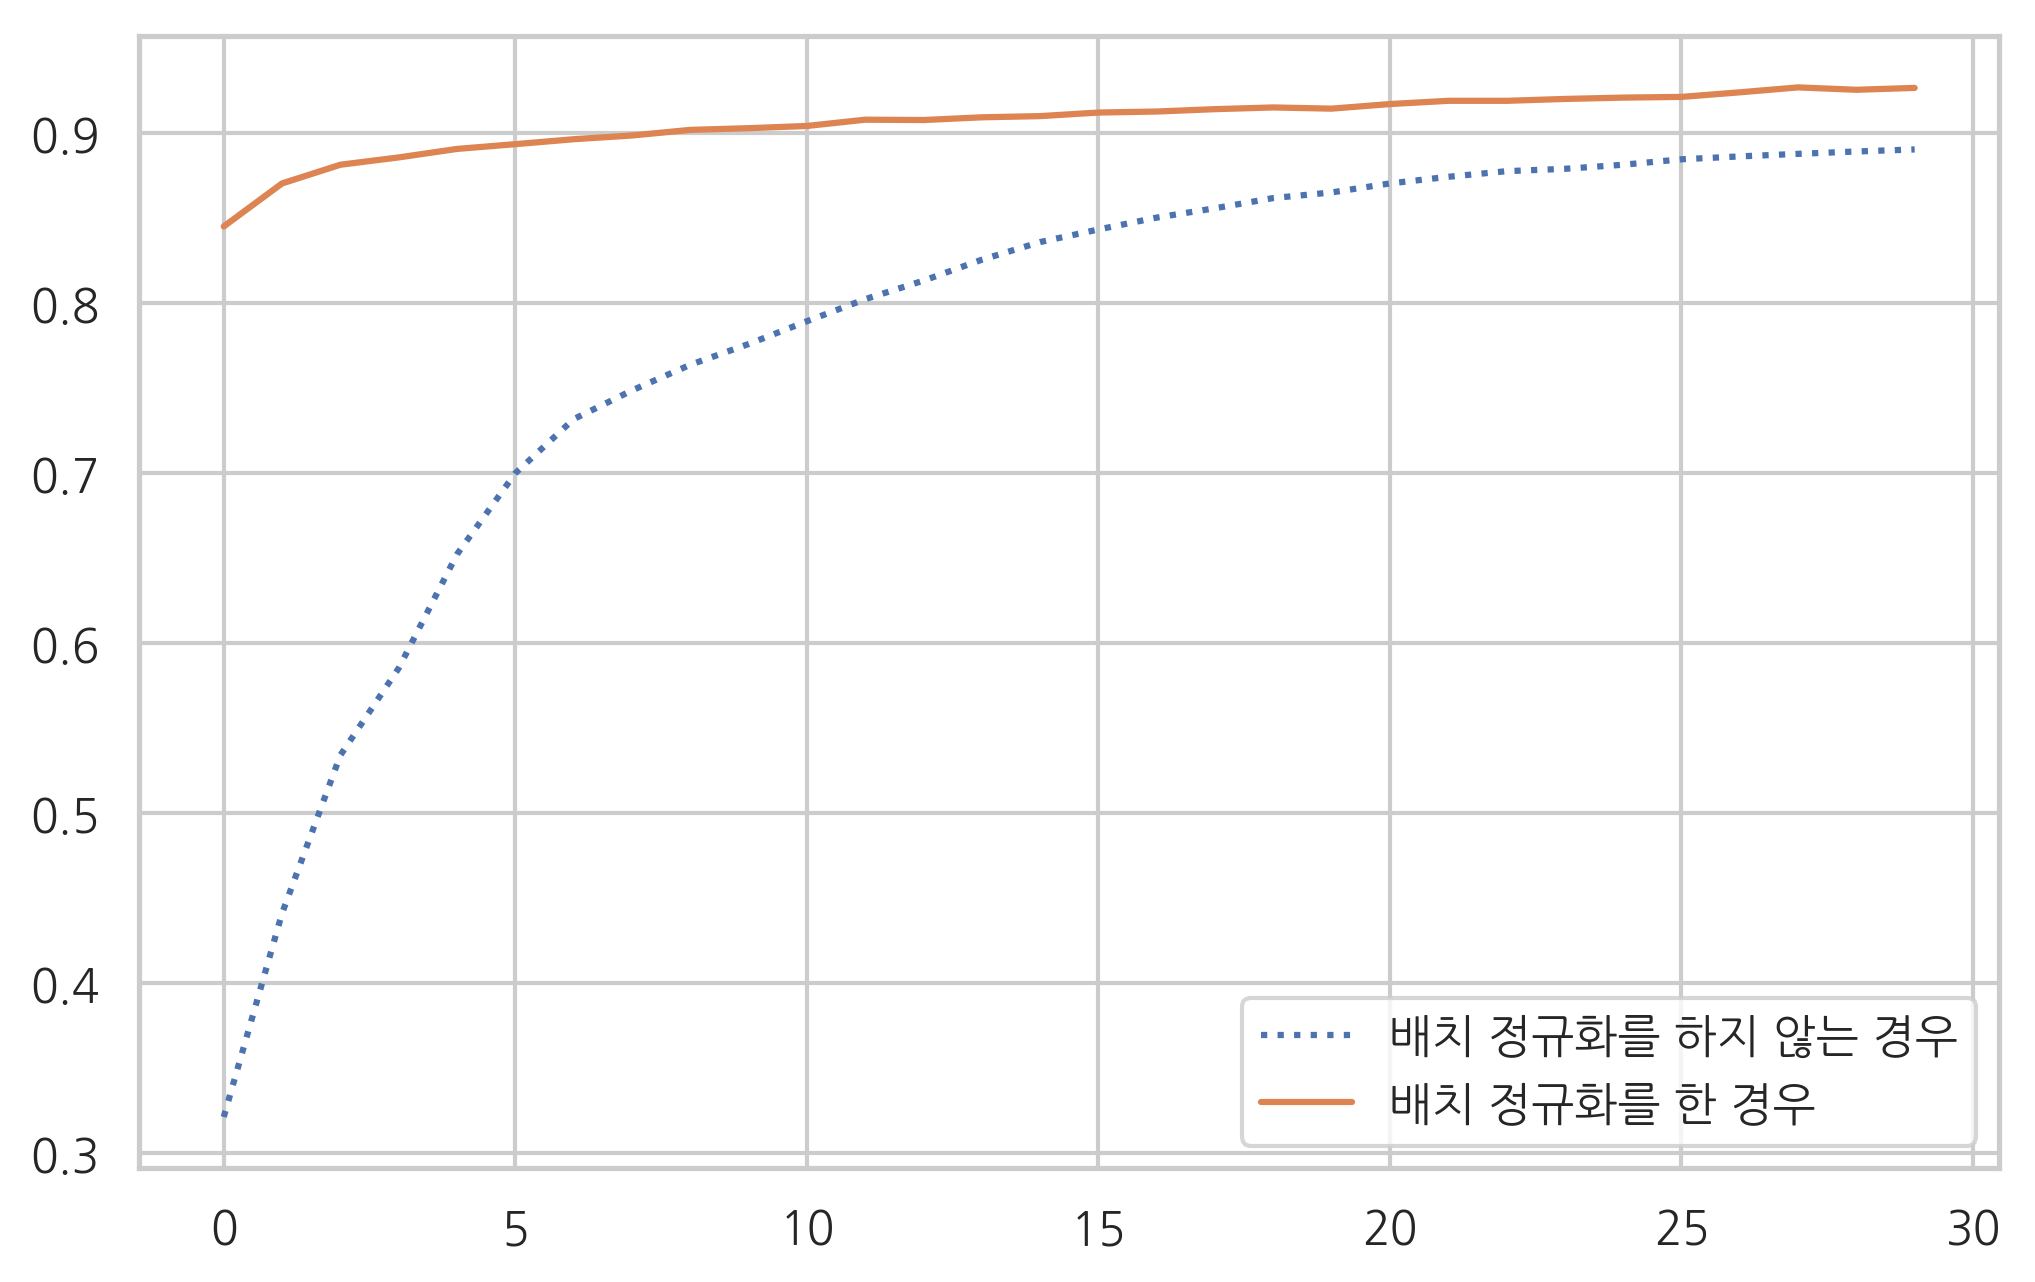

In [34]:
plt.plot(hist0.history['val_acc'], ls=":", label="배치 정규화를 하지 않는 경우")
plt.plot(hist10.history['val_acc'], label="배치 정규화를 한 경우")
plt.legend()
plt.show()